## T cell exhaustion reactivity analysis

## Setup

In [142]:
import warnings
from functools import reduce
import pathlib
import os
from collections import OrderedDict
import seaborn.objects as so
from matplotlib_venn import venn2_circles
from matplotlib_venn import venn2
from seaborn import axes_style
import re
from matplotlib import rcParams
import sys 
sys.path.append("../../bin/")
from reactivity_change_algorithm import *
from protein_domain_analysis import *

%load_ext autoreload
%autoreload 2

sns.set_theme(style="white")
warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
# data paths
input_folder_path = pathlib.Path("/Users/henrysanford/dev/reactivity")
combined_path = input_folder_path / "04_combined_files" / "20240821_5_rep_variability_filter"
dgea_rnaseq_data_dir_path = pathlib.Path("/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/00_rnaseqdata_from_Jahan/13524/results_deseq2")
CONTROL_CONDITION = "D2"
CONDITIONS = ["D4A","D4C","D8A","D8C"]

# make results folder
results_path = pathlib.Path(input_folder_path / "06_results")
pathlib.Path(results_path).mkdir(exist_ok=True)

## Correlation analysis to find experimental outliers

Compare the correlation of every donor across every experimental comparison

In [144]:
df = (
    pd.read_csv(combined_path / "02_combfiles_cysaggr_percctrl_rc.csv", index_col=0)
    .drop(["sequence", "description", "protein"], axis=1)
    .dropna()
    .melt(
        id_vars=["identifier", "uniprot", "residue"],
        var_name="channel_id",
        value_name="percent_control",
    )
)
df[["condition", "experiment", "technical_replicate", "drop"]] = df[
    "channel_id"
].str.split("_", n=3, expand=True)
mean_df = (
    df.drop(["drop", "channel_id", "technical_replicate"], axis=1)
    .groupby(["identifier", "condition", "experiment", "uniprot", "residue"])
    .mean(numeric_only=True)
    .reset_index()
)

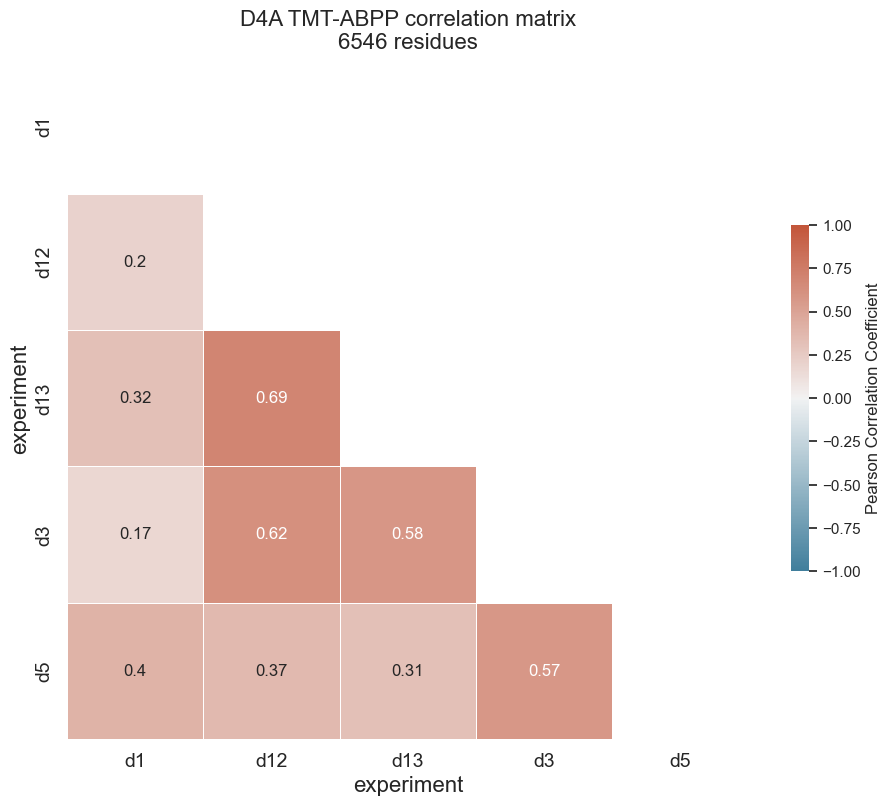

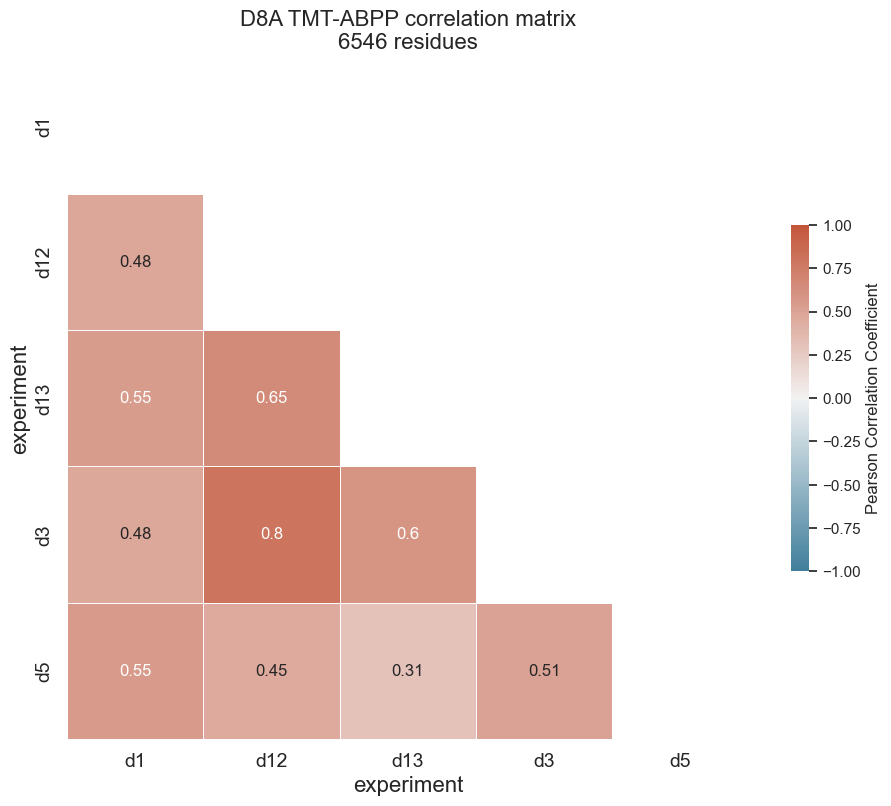

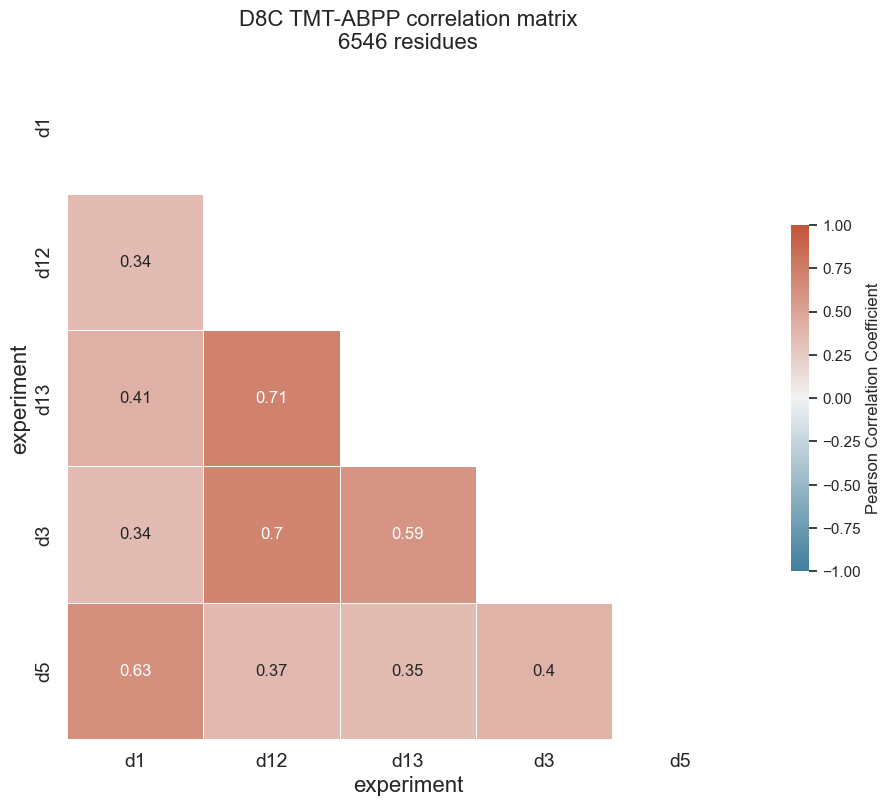

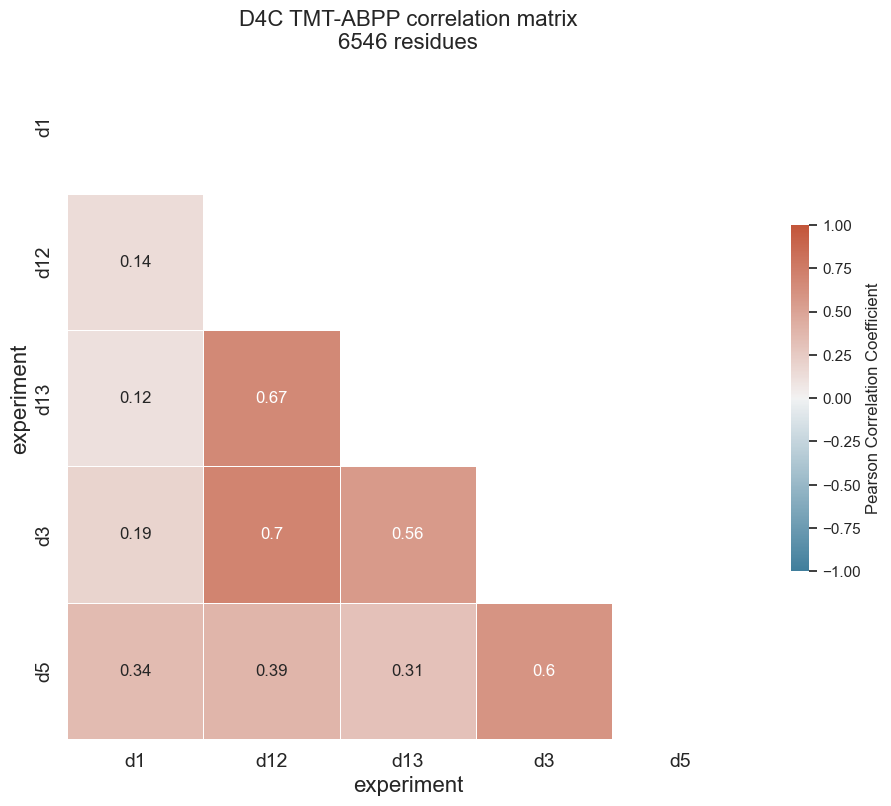

In [145]:
corr_matrix_path = results_path / "01_replicate_correlation_matrix/"
pathlib.Path(corr_matrix_path).mkdir(exist_ok=True)
comparisons = set(mean_df["condition"])
# Do not calculate correlations for the condition we normalized to
comparisons.discard(CONTROL_CONDITION)
for condition in comparisons:
    cond_df = (
        mean_df[mean_df["condition"] == condition]
        .drop("condition", axis=1)
        .pivot(index="identifier", columns="experiment", values="percent_control")
    )
    title = "{} TMT-ABPP correlation matrix\n{} residues".format(
        condition, len(cond_df)
    )
    corr = cond_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    heatmap = sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=1,
        center=0,
        vmin=-1,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5, "label": "Pearson Correlation Coefficient"},
        annot=True,
    )
    heatmap.set_title(title, fontsize=16)
    plt.xlabel("experiment", fontsize=16)
    plt.ylabel("experiment", fontsize=16)
    plt.tick_params(axis="both", which="major", labelsize=14)
    plt.show()

    # save plot
    pathlib.Path(corr_matrix_path).mkdir(exist_ok=True)
    heatmap.get_figure().savefig(
        corr_matrix_path / (title + ".svg"), bbox_inches="tight", transparent=True
    )

How many cysteines are only quantified in one replicate?

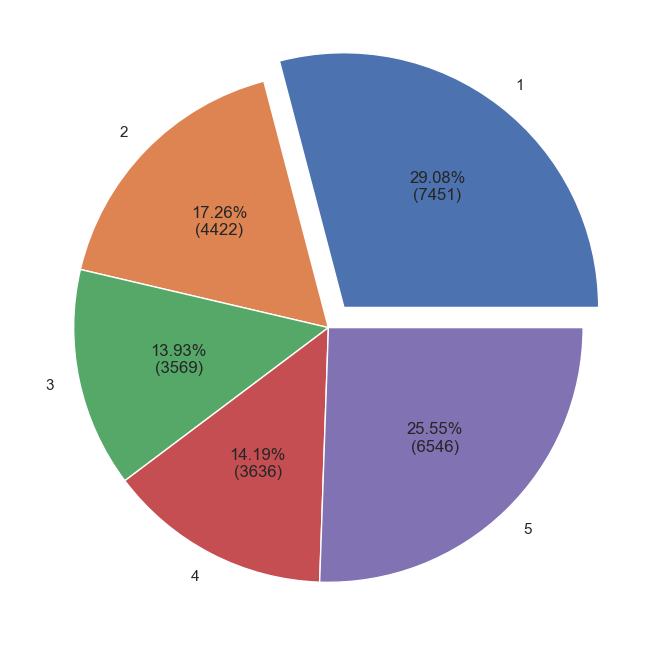

In [146]:
reactivity_path = combined_path / "02_combfiles_cysaggr_percctrl_rc.csv"
df_merged = (pd.read_csv(reactivity_path, index_col=0).drop(["sequence","residue","description","protein"], axis=1)
             .melt(id_vars =["identifier","uniprot"],var_name="channel_id",value_name="percent_control")
             .dropna()
            )
df_merged[["condition","experiment","technical_replicate","drop"]] = df_merged["channel_id"].str.split("_",n=3,expand=True)
df_merged = (df_merged.drop(["percent_control","condition","technical_replicate","drop","channel_id"],axis=1)
             .drop_duplicates()
             .groupby(["identifier","uniprot"])
             .count()
             .reset_index())
pie_df = df_merged.groupby(["experiment"]).count().reset_index()
plt.pie(pie_df["identifier"], labels=pie_df["experiment"],autopct=lambda x: f'{x:.2f}%\n({len(df_merged) *x/100:.0f})',explode = [0.1, 0, 0, 0, 0])
plt.show()

## Detect reactivity changes


Inputs for this algorithm are 

1. WP data
2. TMT-ABPP data
3. Manual curation data

In [147]:
# input - output filepaths
experiment_dir = pathlib.Path(
    "/Users/henrysanford/dev/reactivity/05_reactivity_changes"
)
data_dir = experiment_dir / "input"
result_dir = experiment_dir / "output"
plot_dir = result_dir / "plots"
plot_dir.mkdir(exist_ok=True)

# read whole proteome data
wp_df = pd.read_csv(
    data_dir
    / "10_combcond_percctrl_wp_two_passes_two_replicate_variability_filter.csv",
    index_col=0,
)
# read reactivity data
abpp_df = pd.read_csv(
    data_dir
    / "10_combcond_cysaggr_percctrl_two_passes_two_replicate_variability_filter.csv",
    index_col=0,
)
# read manual curation data
curation_df = pd.read_csv(data_dir / "rc_curation_parsed.csv", index_col=0)

curation_columns = list(curation_df.set_index(["uniprot", "protein"]).columns)

# replace cysteine aggregation seperator
abpp_df["residue"] = abpp_df["residue"].apply(lambda x: x.replace("; ", ","))

Plot number of quantified peptides

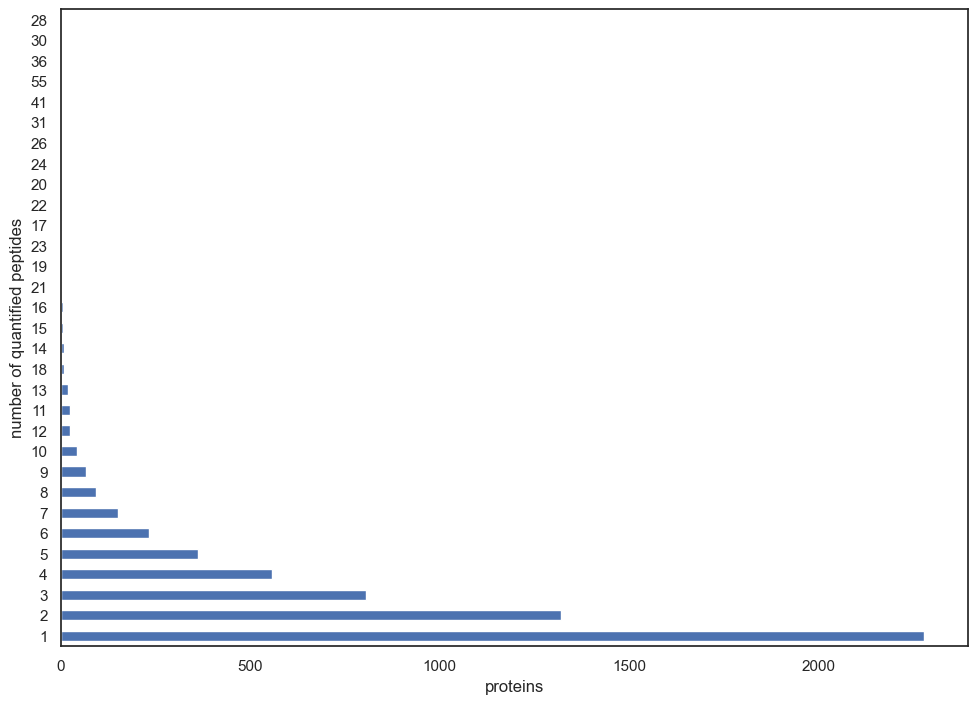

In [148]:
count_df = (
    abpp_df.groupby(["uniprot", "description", "protein"])
    .count()
    .reset_index()[["uniprot", "residue"]]
)
count_df.columns = ["uniprot", "num_quantified_peptides"]
count_df.num_quantified_peptides.value_counts().plot(
    kind="barh", ylabel="number of quantified peptides", xlabel="proteins"
)
abpp_df = abpp_df.merge(right=count_df, how="left", on="uniprot").drop(
    "num_quantified_peptides", axis=1
)
plt.savefig(plot_dir / "peptides_per_protein.svg", bbox_inches="tight")

Format data for algorithm

In [149]:
# prepare reactivity data for filtering
wp_df_to_merge = wp_df.melt(
    id_vars=["uniprot", "description", "protein"],
    var_name="condition",
    value_name="wp_percent_control",
)
abpp_agg_df = (
    abpp_df
    # aggregate multiple cysteine residues to one row
    .melt(
        id_vars=["uniprot", "description", "protein", "sequence", "residue"],
        var_name="condition",
        value_name="percent_control",
    )
    .groupby(["uniprot", "description", "protein", "condition"])
    .agg(list)
    # add whole proteome data
    .merge(
        right=wp_df_to_merge,
        on=["uniprot", "description", "protein", "condition"],
        how="left",
    )
    # filter out control condition
    .loc[lambda df: df.condition != CONTROL_CONDITION]
)

### Run complete algorithm (~4 minutes)

In [150]:
abpp_agg_df = reactivity_change_algorithm(
    abpp_agg_df=abpp_agg_df, curation_df=curation_df
)

### Examine reactivity change results

Plot sum of reactivity changes on the protein and residue level for each condition

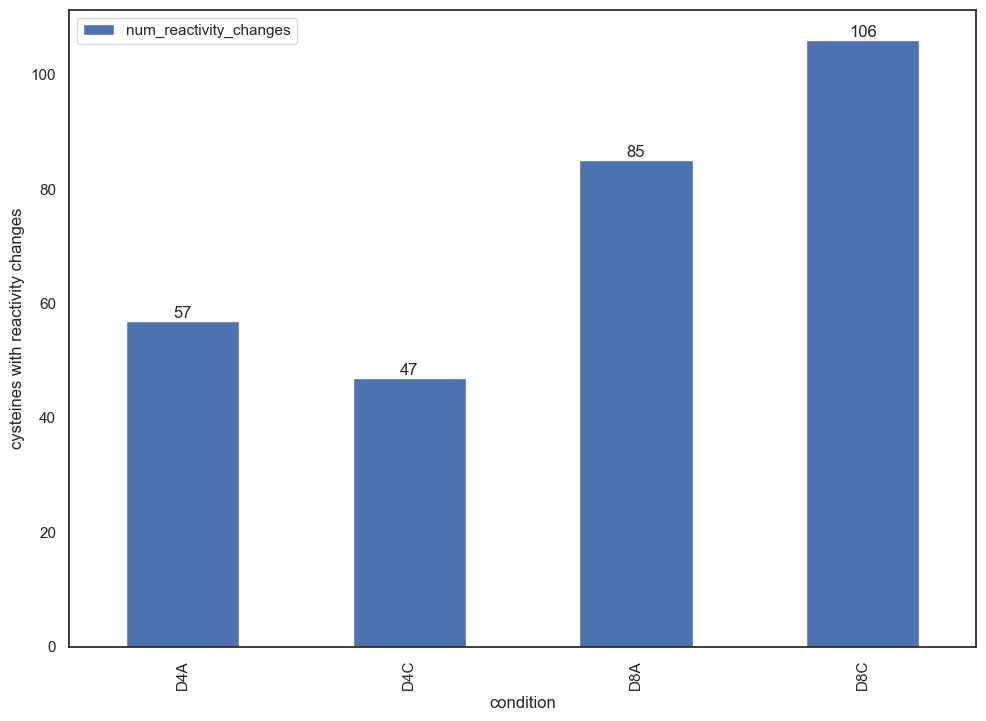

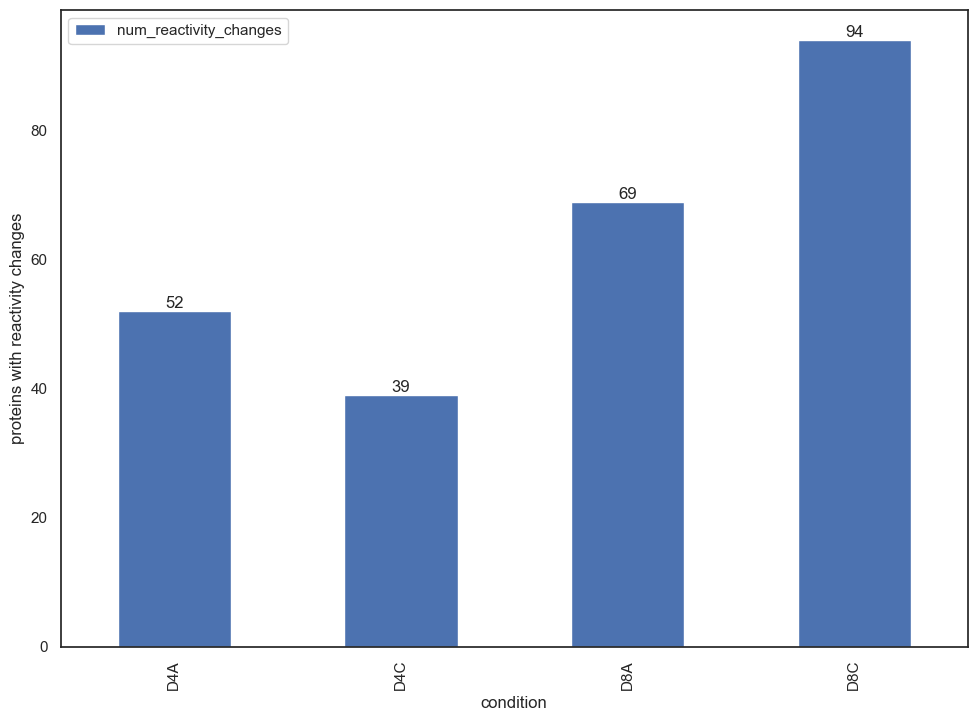

In [151]:
ax = (
    abpp_agg_df[["condition", "num_reactivity_changes"]]
    .groupby("condition")
    .sum()
    .plot(kind="bar", ylabel="cysteines with reactivity changes")
)
for i in ax.containers:
    ax.bar_label(
        i,
    )
plt.savefig(plot_dir / "cysteines_with_reactivity_changes.svg", bbox_inches="tight")

ax = (
    abpp_agg_df[["condition", "num_reactivity_changes"]]
    .loc[lambda df: df.num_reactivity_changes > 0]
    .groupby("condition")
    .count()
    .plot(kind="bar", ylabel="proteins with reactivity changes")
)
for i in ax.containers:
    ax.bar_label(
        i,
    )
plt.savefig(plot_dir / "proteins_with_reactivity_changes.svg", bbox_inches="tight")

In [152]:
df = (
    abpp_agg_df[
        [
            "condition",
            "uniprot",
            "protein",
            "wp_percent_control",
            "num_reactivity_changes",
            "residues_reactivity_changes",
            "TMT_ABPP_reactivity_changes",
        ]
    ]
    .assign(
        median_TMT_ABPP_percent_control=abpp_agg_df["percent_control"].apply(
            lambda x: pd.Series(x).median()
        )
    )
    .loc[abpp_agg_df["num_reactivity_changes"] != 0]
    .explode(["residues_reactivity_changes","TMT_ABPP_reactivity_changes"])
    .apply(assign_directionality, axis =1)
    .to_csv(result_dir / "cysteine_reactivity_changes.csv", index = None)
)

## Format dataset to make more readable

In [153]:
formatted_df = abpp_agg_df.copy()

# set order of columns for clarity
formatted_df = formatted_df[
    [
        "uniprot",
        "description",
        "protein",
        "num_quantified_peptides",
        "curation_color",
        "curation_comments",
        "curation_additional_comments",
        "D4C_curated_residue",
        "D4A_curated_residue",
        "D8A_curated_residue",
        "D8C_curated_residue",
        "two_peptide_no_expression_case",
        "residue",
        "sequence",
        "percent_control",
        "wp_percent_control",
        "passes_bio_replicate_expression_variation_filter",
        "TMT_ABPP_expression_filter",
        "residues_expression_filter",
        "num_expression_filter",
        "TMT_ABPP_median_or_ratio_filter",
        "residues_median_or_ratio_filter",
        "num_median_or_ratio_filter",
        "TMT_ABPP_reactivity_changes",
        "residues_reactivity_changes",
        "num_reactivity_changes",
        "condition",
    ]
]

# lists to formatted strings
for column in formatted_df.columns:
    if not any(
        x in column
        for x in [
            "uniprot",
            "description",
            "protein",
            "condition",
            "wp_percent_control",
            "num",
            "passes_bio_replicate_expression_variation_filter",
            "curation",
            "two_peptide_no_expression_case",
            "curated",
        ]
    ):
        formatted_df[column] = ["|".join(map(str, l)) for l in formatted_df[column]]


# reformat reactivity changes with two peptides and no expression data to make ambiguity clearer
def reformat_two_peptide_no_expression_cases(r):
    if (
        r["two_peptide_no_expression_case"]
        and len(r["residues_reactivity_changes"]) > 1
        and ("|" in r["residues_reactivity_changes"])
    ):
        r["residues_reactivity_changes"] = r["residues_reactivity_changes"].replace(
            "|", ";"
        )
        r["residues_reactivity_changes"] = "(" + r["residues_reactivity_changes"] + ")"
    return r


formatted_df = formatted_df.apply(reformat_two_peptide_no_expression_cases, axis=1)

cond_dfs = []
# build list of columns that are not condition-specific
id_columns = [
    "uniprot",
    "description",
    "protein",
    "two_peptide_no_expression_case",
    "num_quantified_peptides",
]
id_columns.extend(curation_columns)
id_columns.append("sequence")
for condition in ["D4A", "D8A", "D4C", "D8C"]:
    df = (
        formatted_df.loc[lambda df: df.condition == condition]
        .drop("condition", axis=1)
        .set_index(id_columns)
        .add_suffix("_" + condition)
    )
    cond_dfs.append(df)

rc_df = reduce(lambda x, y: x.merge(y, on=id_columns), cond_dfs).reset_index()

### Attatch RNA-Seq data to results

In [154]:
# attatch RNA-Seq data
dgea_rnaseq_data_dir_path = pathlib.Path(
    "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/00_rnaseqdata_from_Jahan/13524/results_deseq2"
)
rename_conditions = {"D4_Ac": "D4A", "D4_Chr": "D4C", "D8_Ac": "D8A", "D8_Chr": "D8C"}

for condition, formatted_condition in rename_conditions.items():
    rna_df = (
        pd.read_csv(
            dgea_rnaseq_data_dir_path
            / "13524_pc_genes_{}_{}_results.csv".format(
                condition.replace("_", "-"), CONTROL_CONDITION
            )
        )
        .rename(
            columns=lambda x: x + "_RNA_{}".format(formatted_condition)
        )  # suffix indicating source
        .rename(columns={"Unnamed: 0_RNA_{}".format(formatted_condition): "protein"})
    )  # rename column to join on

    rc_df = rc_df.merge(
        right=rna_df,  # merge w reactivity data, using proteins from reactivity
        on="protein",
        how="left",
    )
# write to output
rc_df.to_csv(result_dir / "rc_df.csv")

In [157]:
cols_to_filter_on = rc_df.filter(like = "num_reactivity_changes").columns
rc_df_filtered = rc_df[rc_df[cols_to_filter_on].gt(0).any(axis=1)]
rc_df_filtered.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in rc_df_filtered.columns]

columns_to_drop = [] 
columns_to_drop.extend(rc_df_filtered.filter(like = "curated").columns)
columns_to_drop.extend(rc_df_filtered.filter(like = "curation").columns)
columns_to_drop.append("two_peptide_no_expression_case")

rc_df_filtered = rc_df_filtered.drop(columns_to_drop, axis = 1)

rc_df_filtered.to_excel("Data S2-4.xlsx", sheet_name="S2-3 Reactivity changes", startrow=2)

## Compare cysteine reactivity to other molecular datasets

We do not have whole proteome data for all cysteienes we quantified in TMT-ABPP. In order to get another reference for expression changes, we can compare to RNA-Seq data, which is moderately correlated with WP data.


In [35]:
# Merge RNA results with cysteine results
rc_results = pathlib.Path(input_folder_path / "05_reactivity_changes/")
rc_df = pd.read_csv(rc_results / "output/rc_df.csv")
rc_rna_corr_folder = results_path / "04_reactivity_vs_rnaseq"

pathlib.Path(rc_rna_corr_folder).mkdir(exist_ok=True)

# conditions are denoted differently between RNA and protein datasets
rename_conditions = {
    "D4_Ac":"D4A",
    "D4_Chr":"D4C",
    "D8_Ac":"D8A",
    "D8_Chr":"D8C"
}


In [36]:
sp = "|"

def wide_to_long(df, rna=True):
    rows = []
    for index, row in df.iterrows():
        residues = row["residue_{}".format(CONDITIONS[0])].split(sp) # all conditions have the same residues
        for condition in CONDITIONS:
            tmt_abpp_vals = row["percent_control_{}".format(condition)].split(sp)
            exp_fil_residues = str(row["residues_expression_filter_{}".format(condition)]).split(sp)
            exp_fil_vals = str(row["TMT_ABPP_expression_filter_{}".format(condition)]).split(sp)
            median_fil_residues = str(row["residues_median_or_ratio_filter_{}".format(condition)]).split(sp)
            median_fil_vals = str(row["TMT_ABPP_median_or_ratio_filter_{}".format(condition)]).split(sp)
            input_string = str(row["residues_reactivity_changes_{}".format(condition)])
            no_parentheses = re.sub(r"\([^)]*\)", "", input_string)
            no_parentheses = re.sub(r'\(|\)', '', input_string)
            reactivity_change_residues = re.split(r"[;|]", no_parentheses)
            for residue_index, residue in enumerate(residues):
                # make a row for this residue, for this condition
                r = {}
                r["num_quantified_peptides"] = row["num_quantified_peptides"]
                for variable in ["uniprot","protein","description", "curation_color"]:
                    r[variable] = row[variable]
                r["residue"] = residue
                r["condition"] = condition
                r["tmt_abpp"] = tmt_abpp_vals[residue_index]
                r["whole_proteome"] = row["wp_percent_control_{}".format(condition)]
                if rna:
                    r["LFC_RNA"] = row["log2FoldChange_RNA_{}".format(condition)]
                if residue in exp_fil_residues:
                    r["passes_exp_filter"] = True
                    r["TMT_ABPP_exp_filter"] = exp_fil_vals[exp_fil_residues.index(residue)]
                if residue in median_fil_residues:
                    r["passes_median_filter"] = True
                    r["TMT_ABPP_median_filter"] = median_fil_vals[median_fil_residues.index(residue)]
                if residue in reactivity_change_residues:
                    r["reactivity_change"] = True
                rows.append(r)
    return pd.DataFrame(rows)

regulation_palette = {"Higher": "red", "Lower": "blue", "Unchanged or expression based": "grey"}

tc = np.log2(2)
def label_quadrant(row, y):
    y = row[y]
    x = row["LFC_tmt_abpp"]
    if pd.isnull(y):
        return ""
    elif (x < -tc) & (y > np.log2(1/1.6)):
        return "Lower"
    elif (x > tc) & (y < np.log2(1.6)):
        return "Higher"
    else:
        return "Unchanged or expression based"

# This step removes proteins annotated as false positives (red) through manual annotation
plot_data = wide_to_long(rc_df[rc_df["curation_color"] != "red"])

dir = results_path / "03_reactivity_vs_wp"
df1 = plot_data
df1["tmt_abpp"] = pd.to_numeric(df1["tmt_abpp"])
df1["LFC_tmt_abpp"] = np.log2(pd.to_numeric(df1["tmt_abpp"]) / 100)
df1["LFC_WP"] = np.log2(pd.to_numeric(df1["whole_proteome"]) / 100)
df1.to_csv(dir / "rc_df_long_format.csv")
df2 = df1.loc[~df1["whole_proteome"].isnull()]
df2 = df1.loc[~df1["tmt_abpp"].isnull()]
df2["cysteine_reactivity_regulation"] = df2.apply(label_quadrant, y = "LFC_WP",axis=1)
for condition in ["D4A", "D4C","D8C","D8A"]:
    df2[df2["condition"] == condition].to_csv(dir / ("{}_D2_reactivity_wp_comparison_data.csv".format(condition)))

In [37]:
tc = np.log2(2)
def label_quadrant(row, y):
    y = row[y]
    x = row["LFC_tmt_abpp"]
    if pd.isnull(y):
        return ""
    elif (x < -tc) & (y > np.log2(1/1.6)):
        return "Lower"
    elif (x > tc) & (y < np.log2(1.6)):
        return "Higher"
    else:
        return "Unchanged or expression based"

# This step removes proteins annotated as false positives (red) through manual annotation
plot_data = wide_to_long(rc_df[rc_df["curation_color"] != "red"])

dir = results_path / "03_reactivity_vs_wp"
df1 = plot_data
df1["tmt_abpp"] = pd.to_numeric(df1["tmt_abpp"])
df1["LFC_tmt_abpp"] = np.log2(pd.to_numeric(df1["tmt_abpp"]) / 100)
df1["LFC_WP"] = np.log2(pd.to_numeric(df1["whole_proteome"]) / 100)
df1.to_csv(dir / "rc_df_long_format.csv")
df2 = df1.loc[~df1["whole_proteome"].isnull()]
df2 = df1.loc[~df1["tmt_abpp"].isnull()]
df2["cysteine_reactivity_regulation"] = df2.apply(label_quadrant, y = "LFC_WP",axis=1)
for condition in CONDITIONS:
    df2[df2["condition"] == condition].to_csv(dir / ("{}_D2_reactivity_wp_comparison_data.csv".format(condition)))

### Whole proteome

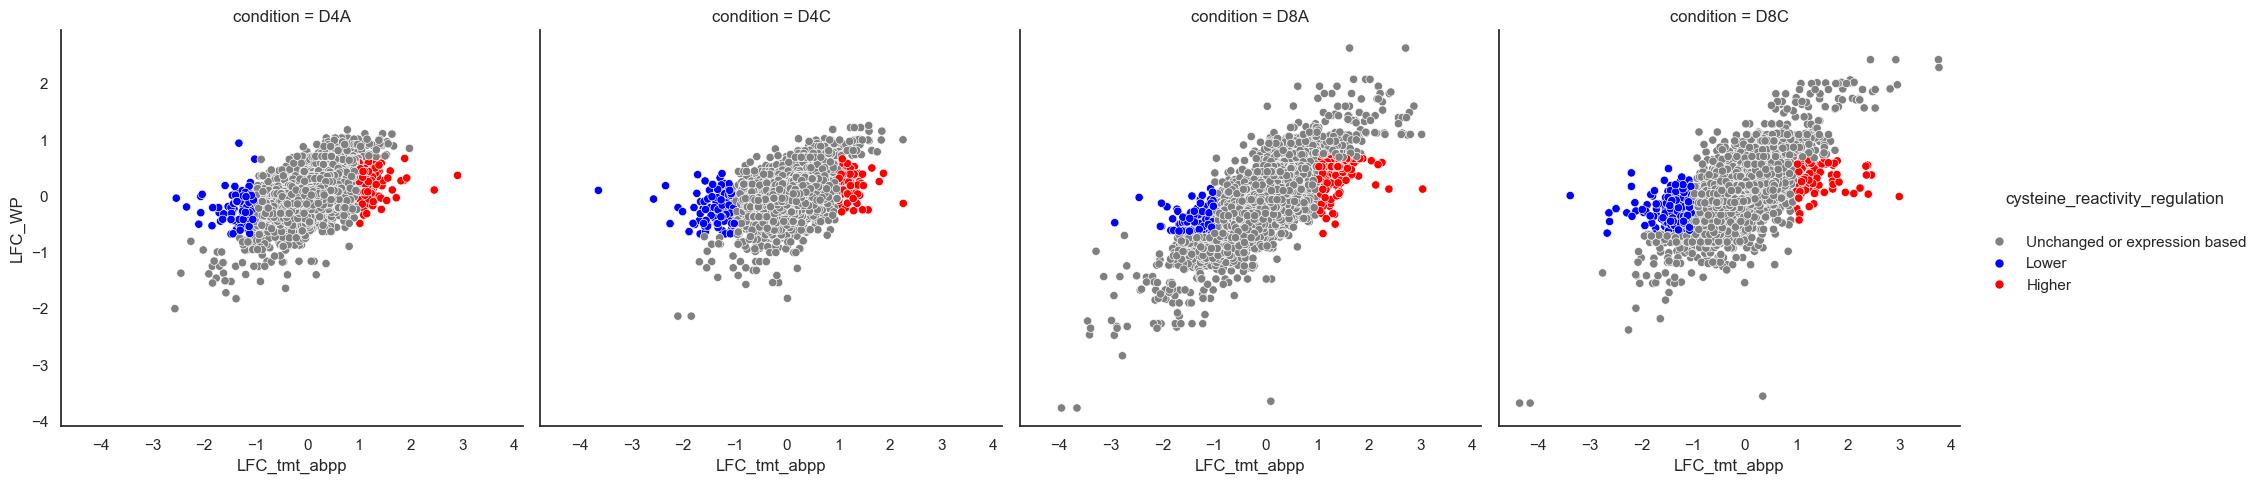

In [38]:
sns.relplot(
    df2,
    x = "LFC_tmt_abpp",
    y = "LFC_WP",
    hue="cysteine_reactivity_regulation",
    palette = regulation_palette,
    col = "condition"
)

### RNA-Seq

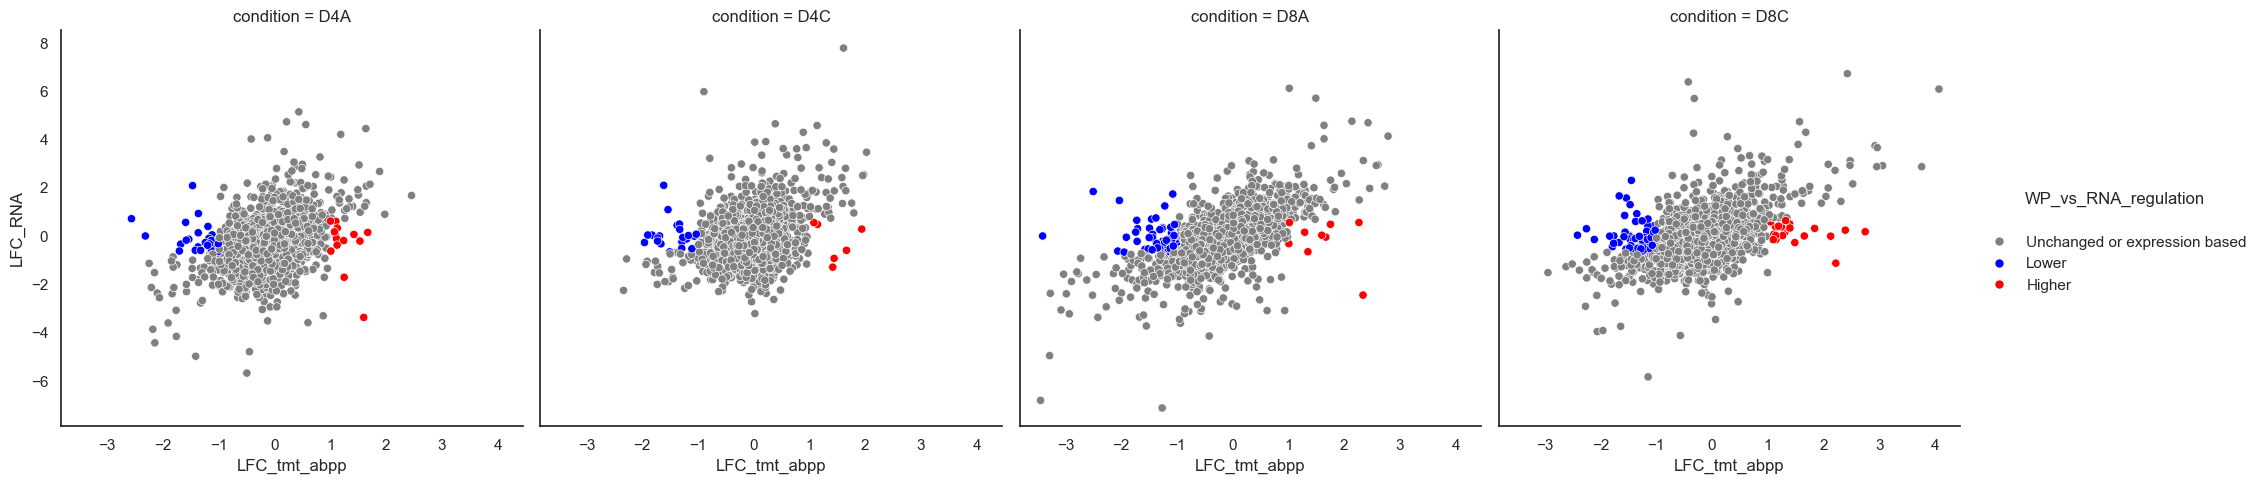

In [39]:
df = plot_data
df["WP_vs_RNA_regulation"] = df.apply(label_quadrant, y = "LFC_RNA",axis=1)
df.to_csv(rc_rna_corr_folder / "rna_rc_wp_plot_data.csv")
sns.relplot(
    data=df[df["num_quantified_peptides"] == 1],
    x="LFC_tmt_abpp",
    y="LFC_RNA",
    col="condition",
    hue = "WP_vs_RNA_regulation",
    palette  = regulation_palette
)

In [ ]:
index_cols = [
            "uniprot",
            "protein",
            "description",
            "residue",
    ]

one_peptide_dir = pathlib.Path("/Users/henrysanford/dev/reactivity_for_plotting")

one_peptide_results = []
for dir in os.listdir(one_peptide_dir):
    print(dir)
    condition = dir.split("_")[0]
    df = pd.read_csv(one_peptide_dir / dir, index_col=0)
    df = df[
        [
            "uniprot",
            "protein",
            "description",
            "residue",
            "LFC_tmt_abpp",
            "LFC_WP",
            "cysteine_reactivity_regulation",
        ]
    ]
    rows = []
    for i,r in df.iterrows():
        if pd.isnull(r["LFC_WP"]):
            r["cysteine_reactivity_regulation"] = ""
        rows.append(r)
    df = pd.DataFrame(rows)
    df = df.set_index(index_cols)
    df.columns = "{} vs {} ".format(condition, "D2") + df.columns
    one_peptide_results.append(df.reset_index())

final_table = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=index_cols,
        how="outer",
    ),
    one_peptide_results,
)
rc_df_filtered.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in rc_df_filtered.columns]
(final_table.sort_values(by = "protein")
 .set_index(index_cols)
 .to_excel(
    "Data S2-4.xlsx",
    sheet_name="Data S2-4 One peptide",
    merge_cells=False,
    startrow=2
))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/henrysanford/dev/reactivity_for_plotting'

In [160]:
df = pd.read_excel(
    "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/12_Supplementary_data/Data S2.xlsx",
    sheet_name = "S2-5 Cysteine reactivity vs WP",
    skiprows = 2
)

df.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in df.columns]

df.to_excel("Data S2-5.xlsx", sheet_name = "S2-5 Cysteine reactivity vs WP")


## Cysteine reactivity rank plots

Most highlighted reactivity changes are expression-based, so this plot is somewhat misleading

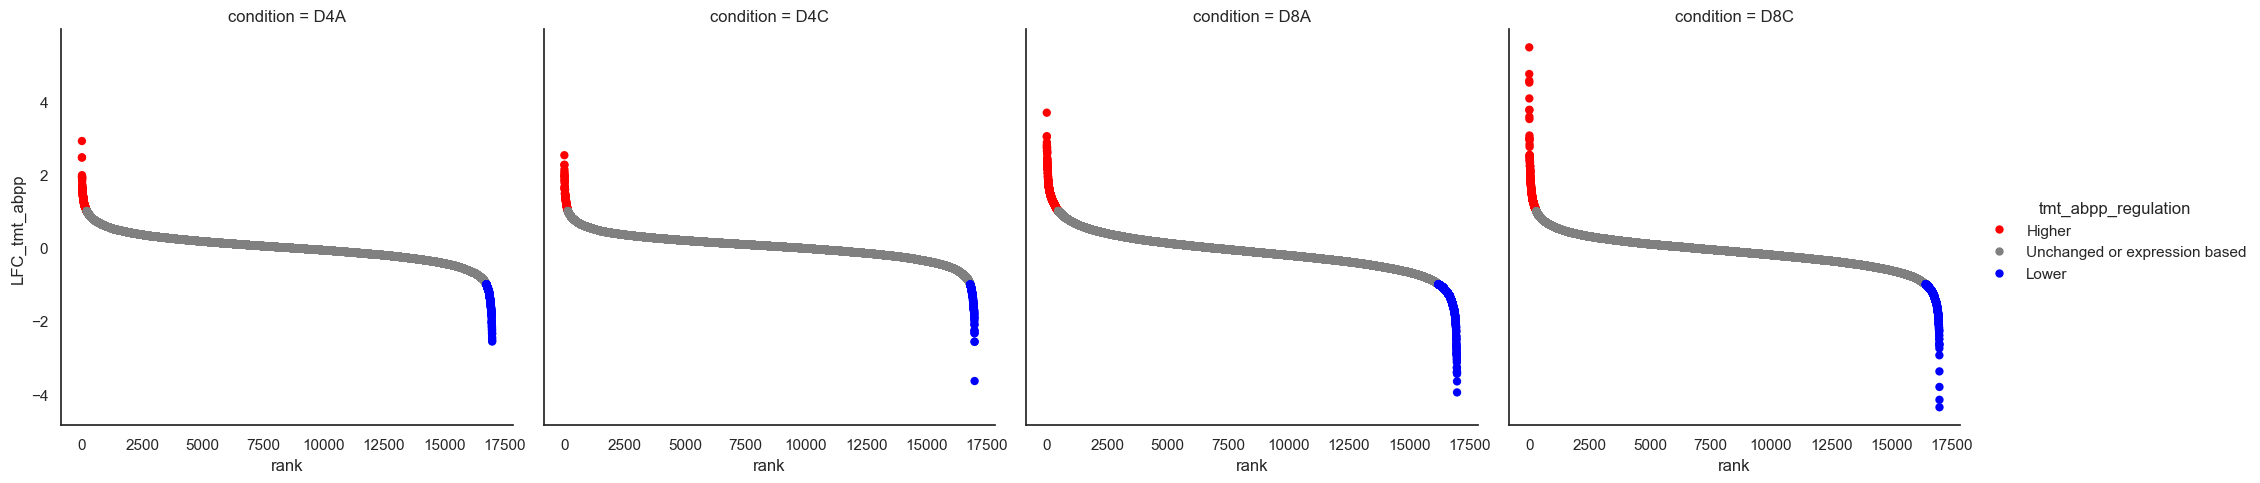

In [ ]:
dir = results_path / "02_cysteine_reactivity_rank"
condition_dfs = []
plot_data["tmt_abpp_regulation"] = plot_data["LFC_tmt_abpp"].apply(
    lambda fc: (
        "Higher" if fc > 1 else "Lower" if fc < -1 else "Unchanged or expression based"
    )
)
for condition in CONDITIONS:
    df = plot_data[plot_data["condition"] == condition].sort_values(
        by="LFC_tmt_abpp", ascending=False
    )
    df.to_csv(dir / "{}_cysteine_reactivity_rank.csv".format(condition))
    df["rank"] = np.arange(0, len(df))
    condition_dfs.append(df)

sns.relplot(
    data=pd.concat(condition_dfs),
    x="rank",
    y="LFC_tmt_abpp",
    hue="tmt_abpp_regulation",
    edgecolor="none",
    palette=regulation_palette,
    col="condition",
)

## Plotting potential targets in gene space

In [ ]:
# load cysteine data split by replicate

df = pd.read_csv(combined_path / "07_combfiles_cysaggr_percctrl_passes_two_replicate_variability_filter.csv", index_col=0)
identifier_vars = ["identifier","uniprot","residue", "sequence", "description", "protein"]
pivot_df = df.melt(id_vars=identifier_vars,var_name="channel_id",value_name="percent_control")
pivot_df["LFC_tmt_abpp"] = np.log2(pivot_df["percent_control"] / 100)
pivot_df[["condition","experiment","technical_replicate","drop"]] = pivot_df["channel_id"].str.split("_",n=3,expand=True)
pivot_df = pivot_df.drop("drop", axis=1).dropna()
identifier_vars.extend(["condition"])
pivot_df["LFC_tmt_abpp_mean"] = pivot_df.groupby(by = identifier_vars).LFC_tmt_abpp.transform('mean')
scatter_data = pivot_df

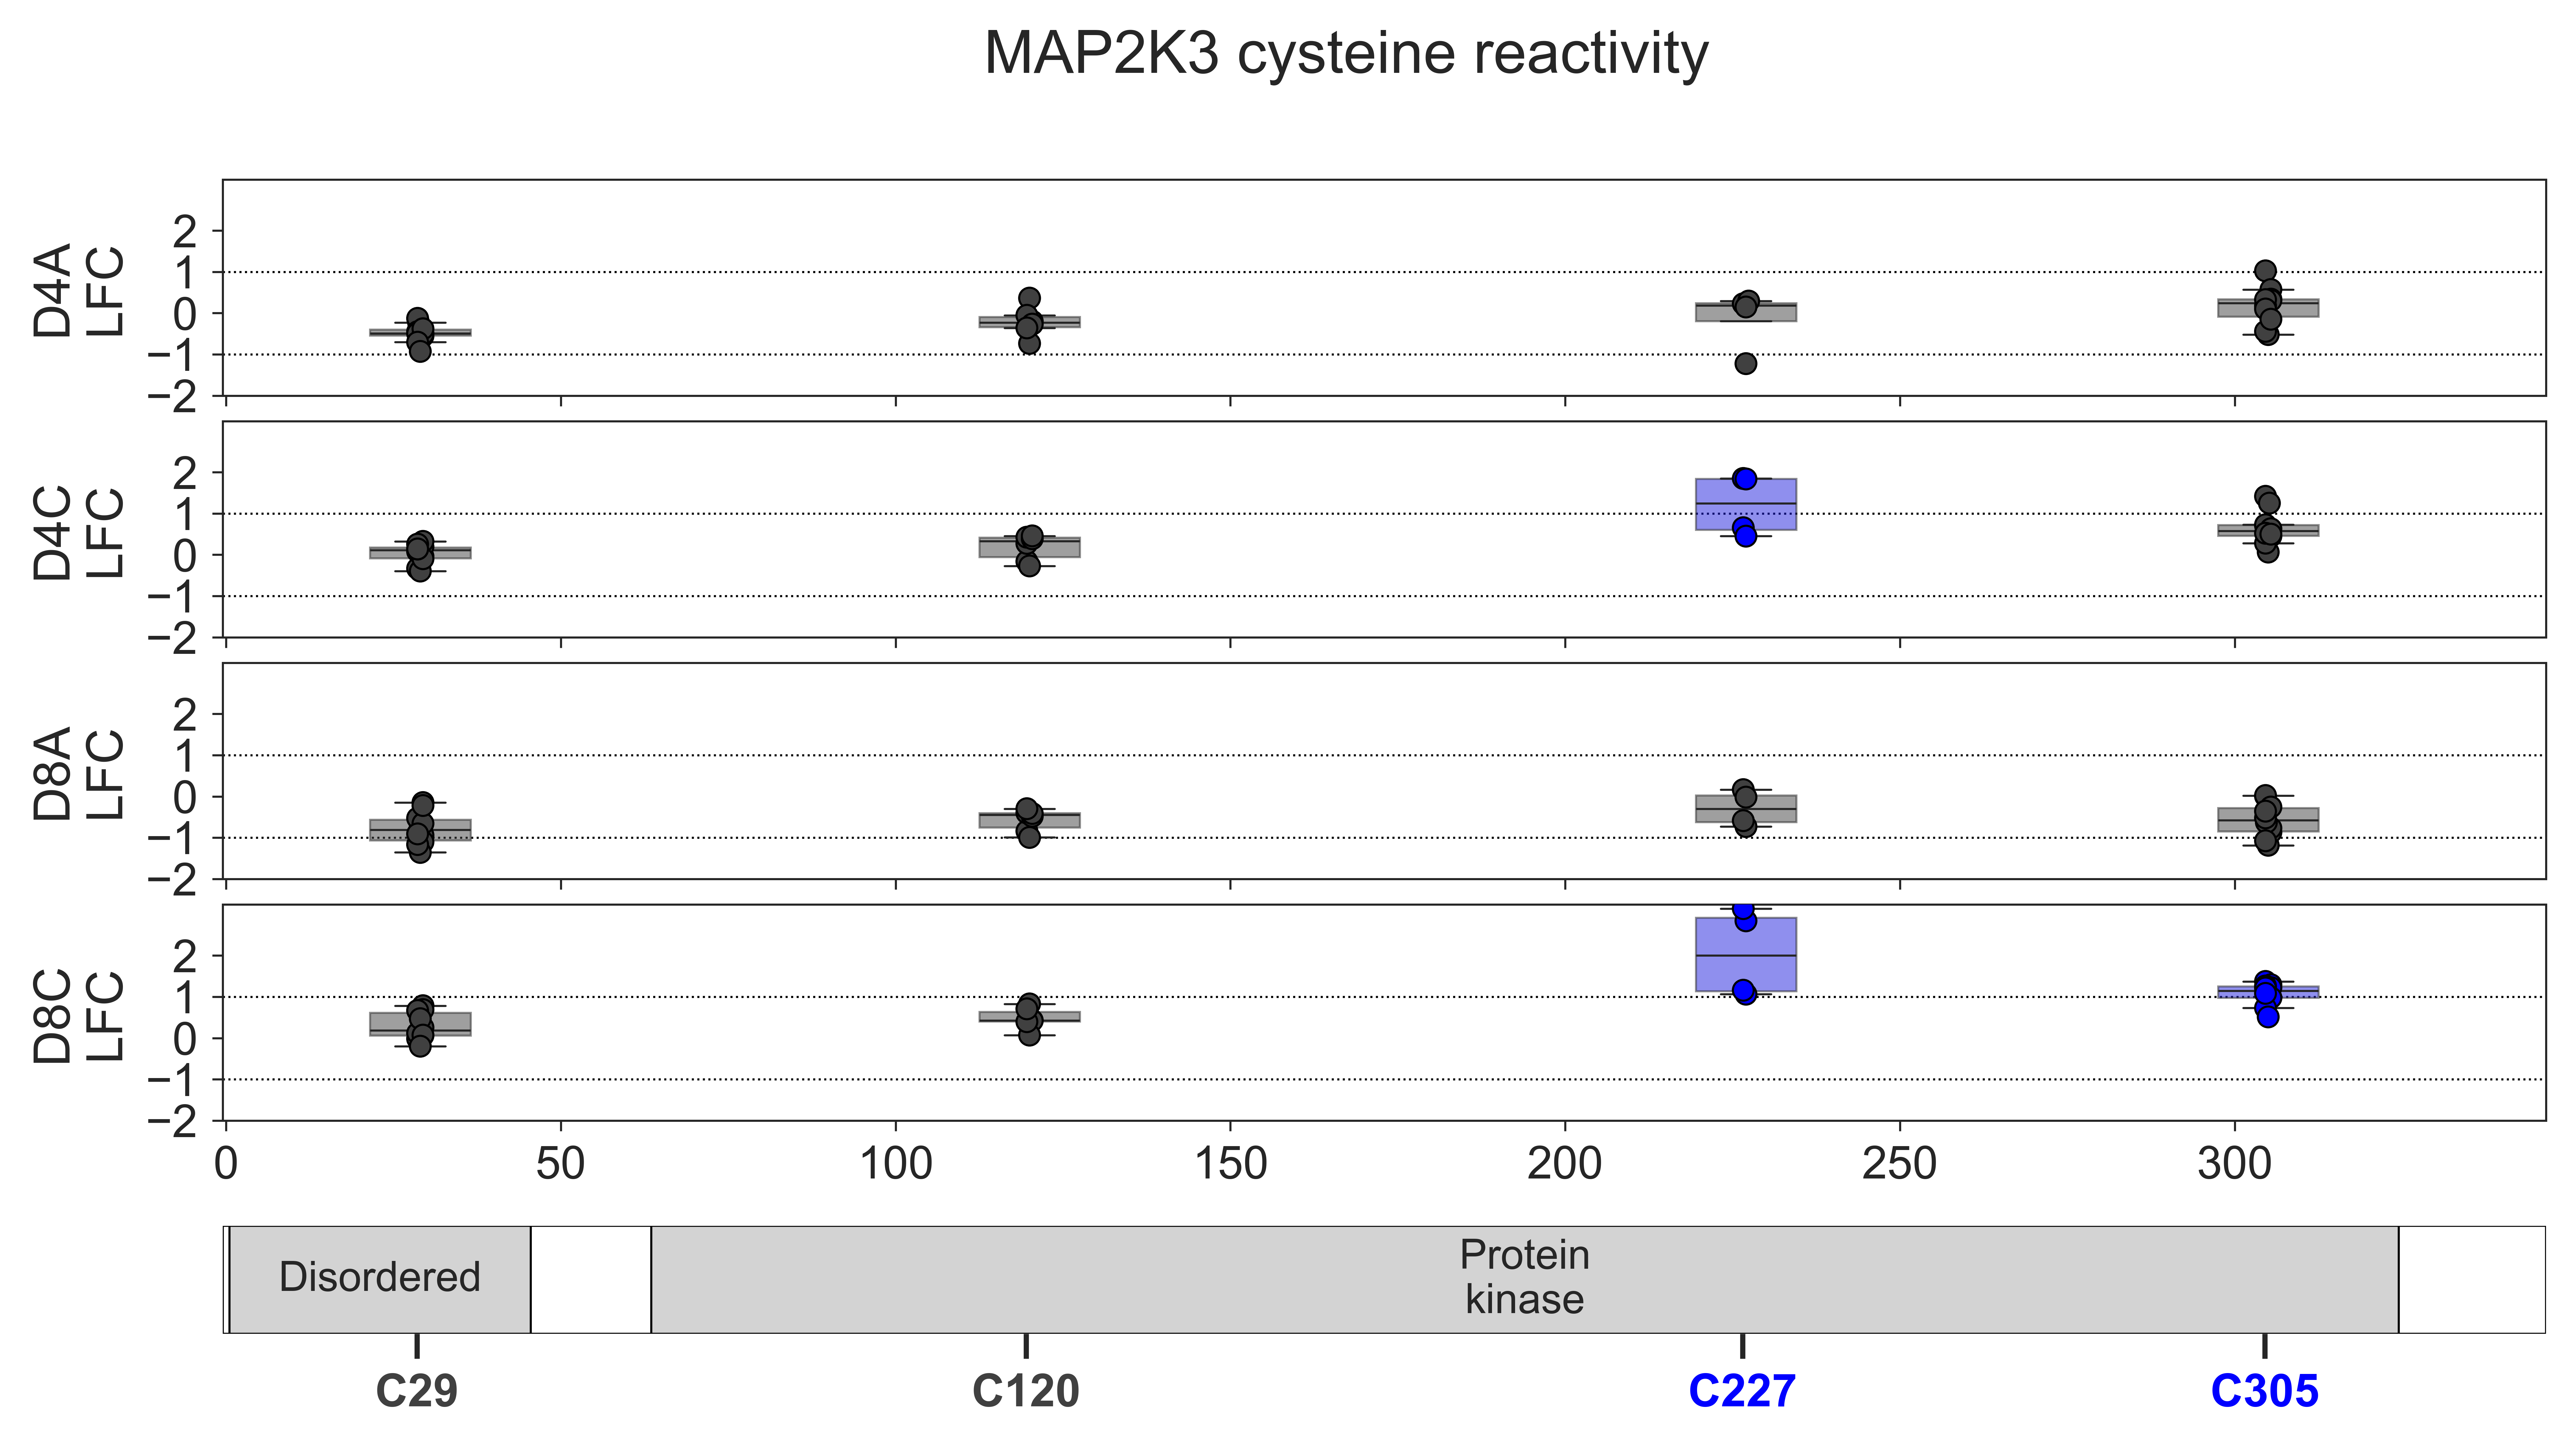

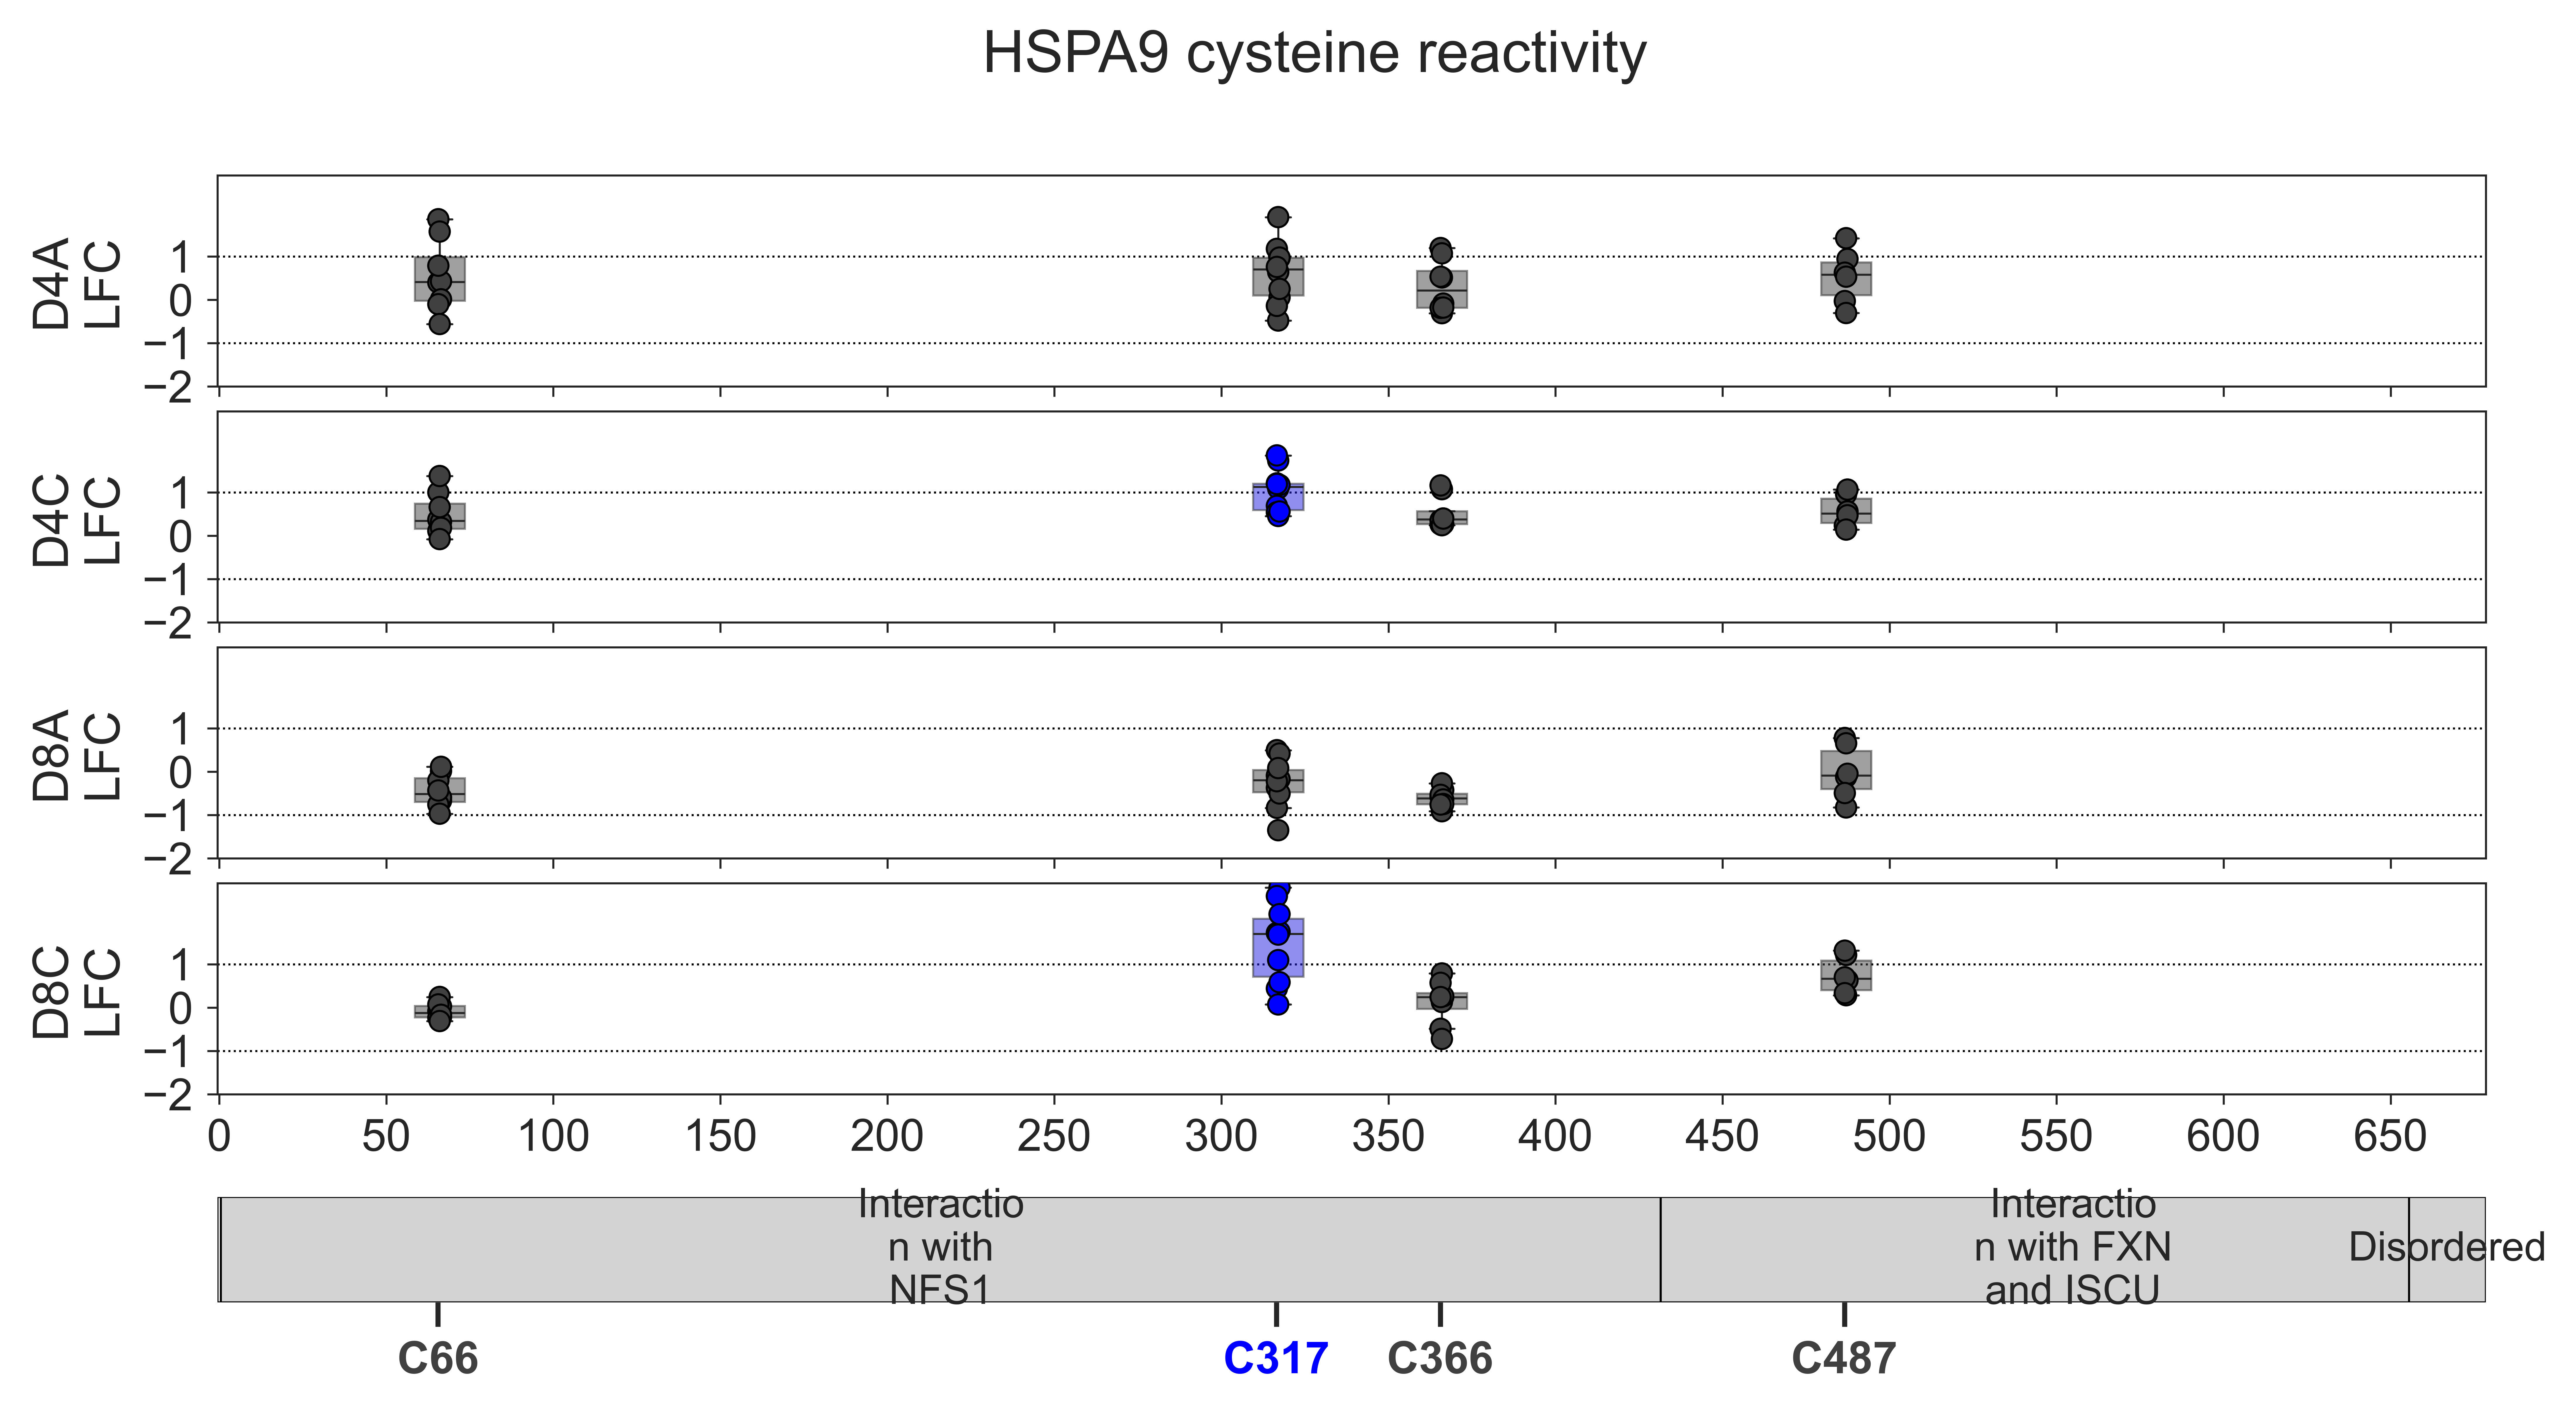

In [ ]:
sns.set_style(style="ticks")
plot_dir = pathlib.Path(
    results_path / "/02_reactivity_plots/"
)
loc_plot(plot_uniprot="P46734", plot_gene="MAP2K3", results_dir=plot_dir, scatter_data=scatter_data)
loc_plot(plot_uniprot = "P38646", plot_gene="HSPA9", results_dir=results_path, scatter_data=scatter_data)

## Annotation of reactivity changes

We want to label where in proteins cysteine reactivity changes are occuring and ideally make a stacked bar graph

Querying UniProt...
Retrieved 0 entries out of 6028
Retrieved 500 entries out of 6028
Retrieved 1000 entries out of 6028
Retrieved 1500 entries out of 6028
Retrieved 2000 entries out of 6028
Retrieved 2500 entries out of 6028
Retrieved 3000 entries out of 6028
Retrieved 3500 entries out of 6028
Retrieved 4000 entries out of 6028
Retrieved 4500 entries out of 6028
Retrieved 5000 entries out of 6028
Retrieved 5500 entries out of 6028
Retrieved 6000 entries out of 6028
Done querying UniProt.
Matching residues to features..


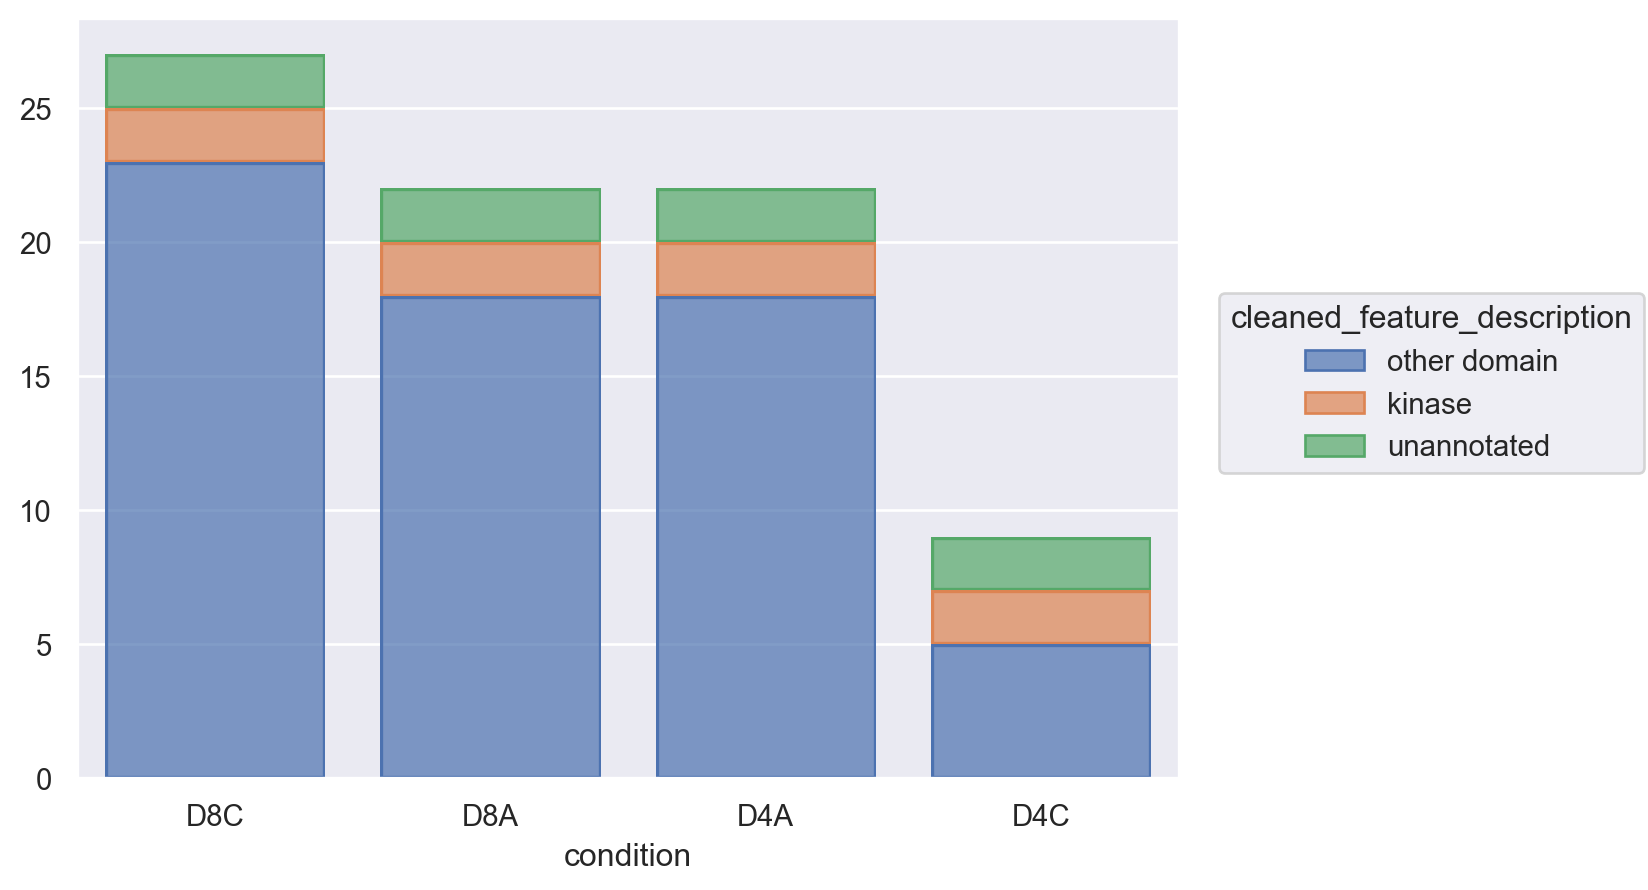

In [ ]:
rc_df = plot_data
entry_dict = create_entry_cache(df)
df = create_feature_df(rc_df, entry_dict)
dir = results_path / "05_domain_annotation"
dir.mkdir(exist_ok=True)
fil_df = df[df["feature_type"].str.contains("Domain|None")]
fil_df = fil_df[fil_df["passes_exp_filter"] == True]
fil_df = fil_df[fil_df["passes_median_filter"] == True]
fil_df.to_csv(dir / "reactivity_changes_domains_annotated.csv")
plot_data = fil_df.groupby(["uniprot", "protein", "residue", "condition"]).agg(list)
plot_data['feature_description'] = [','.join(map(str, l)) for l in plot_data['feature_description']]
count_data = plot_data.reset_index().groupby(["feature_description", "condition"]).count().sort_values(by="residue").reset_index()
domain_renaming = {
    "kinase" : "kinase",
    "None" : "unannotated",
    "SRCR" : "SRCR",
    "MRH" : "MRH"
}
def clean_domain_annotaion(domain_annotation):
    for domain,rename in domain_renaming.items():
        if domain in domain_annotation:
            return rename
    return "other domain"
    
count_data["cleaned_feature_description"] = count_data["feature_description"].apply(clean_domain_annotaion)

theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
so.Plot(count_data, x="condition", color="cleaned_feature_description").add(so.Bar(), so.Count(), so.Stack())#.theme(theme_dict)#.save(dir / "reactivity_changes_domains_stacked_bargraph.svg",)
#plt.savefig(dir / "reactivity_changes_domains_stacked_bargraph.svg", bbox_inches = "tight")
#plt.show()

## Highlighting specific cysteines

In [ ]:
# load cysteine data split by replicate

df = pd.read_csv(combined_path / "07_combfiles_cysaggr_percctrl_passes_two_replicate_variability_filter.csv", index_col=0)

identifier_vars = ["identifier","uniprot","residue", "sequence", "description", "protein"]
pivot_df = df.melt(id_vars=identifier_vars,var_name="channel_id",value_name="percent_control")
pivot_df["LFC_tmt_abpp"] = np.log2(pivot_df["percent_control"] / 100)
pivot_df[["condition","experiment","technical_replicate","drop"]] = pivot_df["channel_id"].str.split("_",n=3,expand=True)
pivot_df = pivot_df.drop("drop", axis=1).dropna()
identifier_vars.extend(["condition"])
pivot_df["LFC_tmt_abpp_mean"] = pivot_df.groupby(by = identifier_vars).LFC_tmt_abpp.transform('mean')
scatter_data = pivot_df
display(scatter_data)
scatter_data.to_csv(results_path / "05_boxplots" / "formatted_replicate_reactivity_data.csv")

identifier uniprot     residue  \
2       A0AVK6_YPNYPNPAVNNDICLDEVAEELNVER_C142_Transcr...  A0AVK6        C142   
3       A0AVT1_ACIGDTLCQK_C449; C455_Ubiquitin-like mo...  A0AVT1  C449; C455   
4       A0AVT1_ALQLLHCFPLDIR_C721_Ubiquitin-like modif...  A0AVT1        C721   
7       A0AVT1_KPNVGCQQDSEELLK_C347_Ubiquitin-like mod...  A0AVT1        C347   
9       A0AVT1_SQCPPIK_C178_Ubiquitin-like modifier-ac...  A0AVT1        C178   
...                                                   ...     ...         ...   
870894  Q9Y6Y0_QISSSSTGCLSSPNATVQSPK_C274_Influenza vi...  Q9Y6Y0        C274   
870895  Q9Y6Y0_QVCGDYLLSR_C121_Influenza virus NS1A-bi...  Q9Y6Y0        C121   
870896  Q9Y6Y8_CPGPLAVANGVVK_C604_SEC23-interacting pr...  Q9Y6Y8        C604   
870898  Q9Y6Y8_IDENYSLPTCK_C814_SEC23-interacting prot...  Q9Y6Y8        C814   
870899  Q9Y6Y8_SIIECVDDFR_C467_SEC23-interacting prote...  Q9Y6Y8        C467   

                          sequence  \
2       YPNYPNPAVNNDICLDEVAEELNVER   
3                       ACIGDTLCQK   
4                    ALQLLHCFPLDIR   
7                  KPNVGCQQDSEELLK   
9                          SQCPPIK   
...                            ...   
870894       QISSSSTGCLSSPNATVQSPK   
870895                  QVCGDYLLSR   
870896               CPGPLAVANGVVK   
870898                 IDENYSLPTCK   
870899                  SIIECVDDFR   

                                              description   protein  \
2       Transcription factor E2F8 OS=Homo sapiens OX=9...      E2F8   
3       Ubiquitin-like modifier-activating enzyme 6 OS...      UBA6   
4       Ubiquitin-like modifier-activating enzyme 6 OS...      UBA6   
7       Ubiquitin-like modifier-activating enzyme 6 OS...      UBA6   
9       Ubiquitin-like modifier-activating enzyme 6 OS...      UBA6   
...                                                   ...       ...   
870894  Influenza virus NS1A-binding protein OS=Homo s...  IVNS1ABP   
870895  Influenza virus NS1A-binding protein OS=Homo s...  IVNS1ABP   
870896  SEC23-interacting protein OS=Homo sapiens OX=9...   SEC23IP   
870898  SEC23-interacting protein OS=Homo sapiens OX=9...   SEC23IP   
870899  SEC23-interacting protein OS=Homo sapiens OX=9...   SEC23IP   

                                               channel_id  percent_control  \
2       D2_d3_1_processed_census-out_051021_EVRU1_32_R...        97.823677   
3       D2_d3_1_processed_census-out_051021_EVRU1_32_R...       105.381563   
4       D2_d3_1_processed_census-out_051021_EVRU1_32_R...       109.960975   
7       D2_d3_1_processed_census-out_051021_EVRU1_32_R...       102.125437   
9       D2_d3_1_processed_census-out_051021_EVRU1_32_R...        99.272141   
...                                                   ...              ...   
870894  D8C_d13_2_processed_census-out_20240405_EV2_68...        99.749572   
870895  D8C_d13_2_processed_census-out_20240405_EV2_68...        90.440690   
870896  D8C_d13_2_processed_census-out_20240405_EV2_68...       104.748042   
870898  D8C_d13_2_processed_census-out_20240405_EV2_68...        58.073896   
870899  D8C_d13_2_processed_census-out_20240405_EV2_68...        56.344624   

        LFC_tmt_abpp condition experiment technical_replicate  \
2          -0.031744        D2         d3                   1   
3           0.075622        D2         d3                   1   
4           0.136992        D2         d3                   1   
7           0.030342        D2         d3                   1   
9          -0.010539        D2         d3                   1   
...              ...       ...        ...                 ...   
870894     -0.003617       D8C        d13                   2   
870895     -0.144956       D8C        d13                   2   
870896      0.066923       D8C        d13                   2   
870898     -0.784038       D8C        d13                   2   
870899     -0.827650       D8C        d13                   2   

        LFC_tmt_abpp_mean  
2               -0

## Subcellular localization of reactivity hits

In [ ]:
reactivity_df = pd.read_csv(input_folder_path / '05_reactivity_changes/output/rc_df.csv')

rc_dict = create_entry_cache(reactivity_df)

rs = []
for i,r in reactivity_df.iterrows():
    locations = []
    if "comments" not in rc_dict[r["uniprot"]]:
        print("comment")
        print(r["uniprot"])
    else:
        for comment in rc_dict[r["uniprot"]]["comments"]:
            if comment["commentType"] == "SUBCELLULAR LOCATION":
                if "subcellularLocations" in comment:
                    for location in comment["subcellularLocations"]:
                        locations.append(location["location"]["value"])
    if len(locations) == 0:
        for db in rc_dict[r["uniprot"]]["uniProtKBCrossReferences"]:
            if db["database"] == "GO":
                for item in db["properties"]:
                    if "C:" in item["value"]:
                        locations.append(item["value"].split("C:")[1])
    r["uniprot_subcellular_location"] = "|".join(locations)
    rs.append(r)

df = pd.DataFrame(rs)

aliases = OrderedDict([
 ("Mitochondrion", "Mitochondrion"), 
 ("mitochondrion", "Mitochondrion"), 
 ("Nucleus", "Nucleus"),
 ("nucleus", "Nucleus"),
 ("Peroxisome", "Peroxisome"),
 ("Lysosome", "Lysosome"),
 ("Endoplasmic reticulum", "Endoplasmic reticulum"),
 ("Cell membrane", "Membrane"), 
 ("membrane", "Membrane"), 
 ("Membrane", "Membrane"), 
 ("Cytoplasm", "Cytoplasm"), 
 ("cytoplasm", "Cytoplasm"),
 ("cytosol", "Cytoplasm"),
 ])

def clean_subcellular_location(x):
    for compartment in aliases.keys():
        if compartment in x:
            return aliases[compartment]
    else:
        return "Other"
df["cleaned_subcellular_location"] = df["uniprot_subcellular_location"].apply(clean_subcellular_location)

df.to_csv(input_folder_path / '05_reactivity_changes/output/rc_df_with_subcellular_location.csv')

def add_loc(df):
    rs = []
    for i,r in df.iterrows():
        locations = []
        if "comments" not in rc_dict[r["uniprot"]]:
            print("comment")
            print(r["uniprot"])
        else:
            for comment in rc_dict[r["uniprot"]]["comments"]:
                if comment["commentType"] == "SUBCELLULAR LOCATION":
                    if "subcellularLocations" in comment:
                        for location in comment["subcellularLocations"]:
                            locations.append(location["location"]["value"])
        if len(locations) == 0:
            for db in rc_dict[r["uniprot"]]["uniProtKBCrossReferences"]:
                if db["database"] == "GO":
                    for item in db["properties"]:
                        if "C:" in item["value"]:
                            locations.append(item["value"].split("C:")[1])
        r["uniprot_subcellular_location"] = "|".join(locations)
        rs.append(r)

    df = pd.DataFrame(rs)
    df["cleaned_subcellular_location"] = df["uniprot_subcellular_location"].apply(clean_subcellular_location)
    return(df)

Querying UniProt...
Retrieved 0 entries out of 6028
Retrieved 500 entries out of 6028
Retrieved 1000 entries out of 6028
Retrieved 1500 entries out of 6028
Retrieved 2000 entries out of 6028
Retrieved 2500 entries out of 6028
Retrieved 3000 entries out of 6028
Retrieved 3500 entries out of 6028
Retrieved 4000 entries out of 6028
Retrieved 4500 entries out of 6028
Retrieved 5000 entries out of 6028
Retrieved 5500 entries out of 6028
Retrieved 6000 entries out of 6028
Done querying UniProt.
comment
P0DMB2
comment
Q5T6C5
comment
Q6DCA0
comment
Q7Z7L8
comment
Q8IXQ3
comment
Q8NCJ5
comment
Q96CP2
comment
Q96FK6
comment
Q9ULL1


## ATP add back

In [161]:
add_back_dir = pathlib.Path('/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/10_metabolites/02_rc_analysis/20241107_tex_metab_2reps_2MC')
combfiles = pd.read_csv((add_back_dir / '04_combined_files/20241107_tex_metab_2reps_2MC/07_combfiles_cysaggr_percctrl_passes_two_replicate_variability_filter.csv'), index_col = 0)
fewer_than_two_reps = pd.read_csv(add_back_dir / '04_combined_files/20241107_tex_metab_2reps_2MC/08_combfiles_cysaggr_percctrl_fewer_than_2_replicates.csv')
combfiles = combfiles[combfiles["uniprot"] != "contaminant"]

# replace cysteine aggregation separator
combfiles["residue"] = combfiles["residue"].str.replace("; ", ", ")

t_combfiles = (combfiles[~combfiles["identifier"].isin(fewer_than_two_reps["identifier"])]
 .melt(id_vars=["identifier","uniprot", "sequence","residue","description","protein"],
       var_name="channel_name",
       value_name="percent_control"))


t_combfiles = (combfiles
 .melt(id_vars=["identifier","uniprot", "sequence","residue","description","protein"],
       var_name="channel_name",
       value_name="percent_control"))

t_combfiles[["condition","experiment","technical_replicate","drop"]] = t_combfiles["channel_name"].str.split("_",n=3,expand=True)

t_combfiles = t_combfiles.drop("drop", axis = 1)

t_combfiles["residue_loc"] = t_combfiles["residue"].apply(lambda x: int(x.split("C")[1].split(",")[0]))

t_combfiles["condition"] = [x.replace("-MgCl2", "") for x in t_combfiles["condition"] ]

t_combfiles.to_csv(add_back_dir / '06_results/boxplots/formatted_reactivity_data.csv')

In [162]:
processed_combfiles = combfiles.copy()

conditions = [
    "D2-MgCl2",
    "D2-ATP-MgCl2",
    "D8A-MgCl2",
    "D8A-ATP-MgCl2",
    "D8C-MgCl2",
    "D8C-ATP-MgCl2",
]

for condition in conditions:
    condition_columns = combfiles.filter(like=condition).columns
    processed_combfiles["median_{}".format(condition)] = combfiles[
        condition_columns
    ].median(axis=1)
ratio_combfiles = processed_combfiles.copy()

for super_condition in ["D2", "D8A", "D8C"]:
    ratio_combfiles["ratio_{}_+/-_ATP".format(super_condition)] = (
        processed_combfiles["median_{}-ATP-MgCl2".format(super_condition)]
        / processed_combfiles["median_{}-MgCl2".format(super_condition)]
    )
    ratio_combfiles["regulation_{}_+/-_ATP".format(super_condition)] = ratio_combfiles[
        "ratio_{}_+/-_ATP".format(super_condition)
    ].apply(lambda x: "Higher" if x > 2 else "Lower" if x < 0.5 else "Unchanged")

# by comparing ratio of +/- ATP between conditions, we determine which cysteines
# are more ATP sensitive in D8C compared to D2 and so on. Calculate this labeling for
# each possible comparison.
for comparison in [["D8C", "D2"], ["D8A", "D2"], ["D8C", "D8A"]]:
    condition = comparison[0]
    control = comparison[1]
    atp_ratio_column = "ratio_({}_+/-_ATP)/({}_+/-_ATP)".format(condition, control)
    ratio_combfiles[atp_ratio_column] = (
        ratio_combfiles["ratio_{}_+/-_ATP".format(condition)]
        / ratio_combfiles["ratio_{}_+/-_ATP".format(control)]
    )
    ratio_combfiles[
        "ATP_sensitivity_{}_vs_{}".format(condition, control)
    ] = ratio_combfiles[atp_ratio_column].apply(
        lambda x: (
            "More ATP sensitive at {}".format(control)
            if x > 2
            else ("More ATP sensitive at {}".format(condition) if x < 0.5 else "Unchanged")
        )
    )

def proteasome_subunit_family(x):
    for sub_family in ["A","B","C", "D"]:
        if x.startswith("PSM" + sub_family):
            return "PSM" + sub_family
    return "Other"

ratio_combfiles["proteasome_subunit_family"] = ratio_combfiles["protein"].apply(proteasome_subunit_family)

ratio_combfiles.to_csv(
    add_back_dir / "06_results/protein_table_ATP_add_back_2_reps.csv"
)

# melt regulation data of cysteines into long format for plotting
# in a stacked barplot
t_regulation = ratio_combfiles.melt(
    id_vars=["identifier", "uniprot", "sequence", "residue", "description"],
    value_vars=ratio_combfiles.filter(like="regulation").columns,
)

t_regulation["condition"] = t_regulation["variable"].str.split(
    "regulation_", n=1, expand=True
)[1]
t_regulation.to_csv(
    add_back_dir / "06_results/bargraphs/formatted_add_back_regulation.csv"
)

In [171]:
ratio_combfiles.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in ratio_combfiles.columns]
ratio_combfiles.to_excel("Data S2-6.xlsx")

Reactivity changes only:
GYS1_C699, CHUK_C30, CRBN_C287, TBC1D4_C45, MAT2A_C56, NPM3_C79, EDARADD_C64, TNIP2_C144, BAG5_C327, NDUFV1_C206, MYO19_C275, FASN_C2468, NAP1L1_C388, DDB2_C295, ACSL4_C494, C495, POLR2I_C42, C52, IKZF1_C394, PSMD9_C81, TUFM_C225, HSPH1_C650, TRMT1L_C239, PRPF8_C435, MRPL3_C338, SCRIB_C1612, ZNF414_C311, ZYX_C387, NSUN2_C758, MAT2A_C104, BDH1_C221, ABCF2_C186, TBC1D4_C74, GRPEL1_C124, INTS13_C331
Sites in both:
ACSL3_C450, SRPRB_C246, MAP2K3_C305, UPF2_C944, LONP1_C682, NTPCR_C110, HSPA9_C317, HNRNPU_C594, PLS3_C33, MAP2K4_C246, PSMC5_C209
ATP-sensitive only:
MDN1_C1867, GLYR1_C303, NMRK1_C125, PFKP_C664, INTS12_C379, ABCF2_C586, PSMC4_C210, EXOSC9_C122, MAP2K5_C300, SMC2_C46, PCK2_C306, HNRNPU_C607, SPG7_C353, SRRM2_C956, ACSS1_C422, CHTF18_C373, ABCD3_C472, C477, IARS1_C526, RIOK2_C365, C367, UBA2_C30, PIKFYVE_C723, PSMC3_C240, ATP6V1A_C240, C254, RFC2_C171, CHEK2_C231, MAT2B_C58, ATP13A1_C723, RAD21_C585, GCN1_C55, HPRT1_C23, NVL_C309, ATAD3B_C461, UBE2N_C87

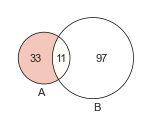

In [164]:
reactivity_df = plot_data.copy()
add_back_df = ratio_combfiles.copy()

condition = "D8C"

# add protein + resiude identifier
reactivity_df["id"] = reactivity_df["protein"] + "_" + reactivity_df["residue"].str.replace(",", ", ")
add_back_df["id"] = add_back_df["protein"] + "_" + add_back_df["residue"]

# filter to resiudes quantified in both datasets
add_back_df = add_back_df[add_back_df["id"].isin(reactivity_df["id"])]
reactivity_df = reactivity_df[reactivity_df["id"].isin(add_back_df["id"])]

# filter to reactivity changes
reactivity_changes = set(
    reactivity_df[
        (reactivity_df["condition"] == condition) & (reactivity_df["reactivity_change"])
        == True
    ]["id"]
)

# filter to ATP-sensitive sites
atp_sensitive_sites = set(
    add_back_df[add_back_df["ratio_{}_+/-_ATP".format(condition)] < 1 / 2]["id"]
)


peptide_sets = [reactivity_changes, atp_sensitive_sites]

plt.figure(figsize=(1.7, 1.7))

out = venn2(
    subsets=peptide_sets,
    set_colors=["#E27753", "white"],
    #set_labels=[
    #    "Reactivity changes at {}".format(condition),
    #    "ATP-sensitive sites at {}".format(condition),
    #],
)

for text in out.subset_labels:
    text.set_fontsize(8)
    text.set_family("Arial")
for text in out.set_labels:
    text.set_fontsize(8)
    text.set_family("Arial")

venn2_circles(subsets=peptide_sets, linewidth=0.5)

print(
    "Reactivity changes only:\n"
    + ", ".join(list(reactivity_changes.difference(atp_sensitive_sites)))
)
print("Sites in both:\n" + ", ".join(list(reactivity_changes.intersection(atp_sensitive_sites))))
print("ATP-sensitive only:\n" + ", ".join(list(atp_sensitive_sites.difference(reactivity_changes))))
plt.savefig(
    add_back_dir / "atp_sensitivity_venn.pdf",
    bbox_inches = "tight"
)

print(reactivity_changes.intersection(atp_sensitive_sites))

### Sequence analysis

Examine the frequency of amino acids around cysteines experiencing a reactivity change with the addition of ATP

regulation_D2_+/-_ATP
regulation_D8A_+/-_ATP
regulation_D8C_+/-_ATP


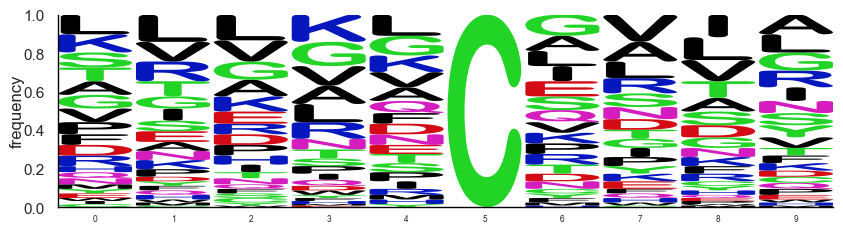

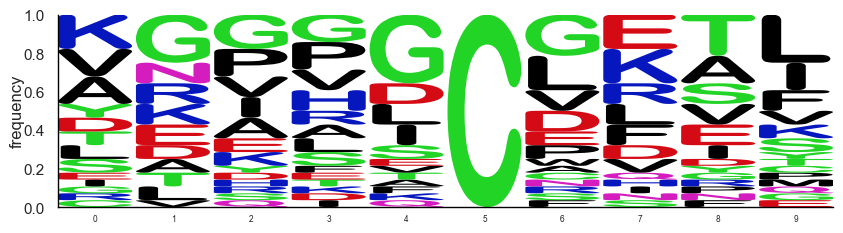

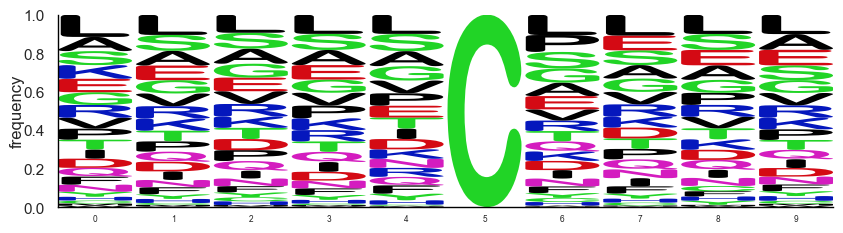

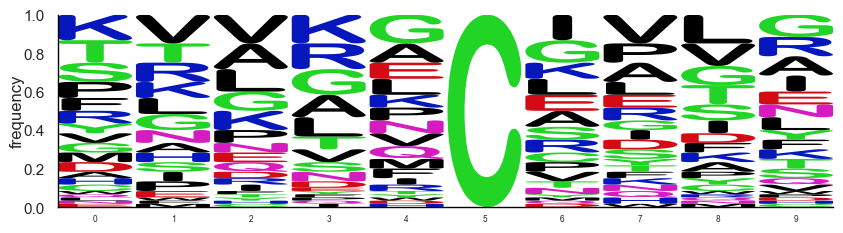

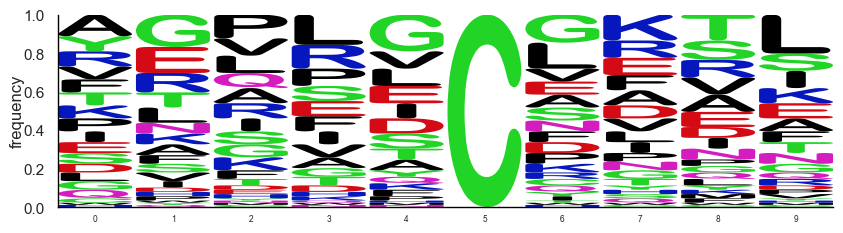

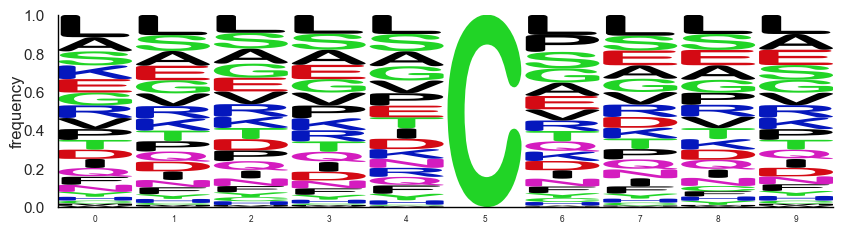

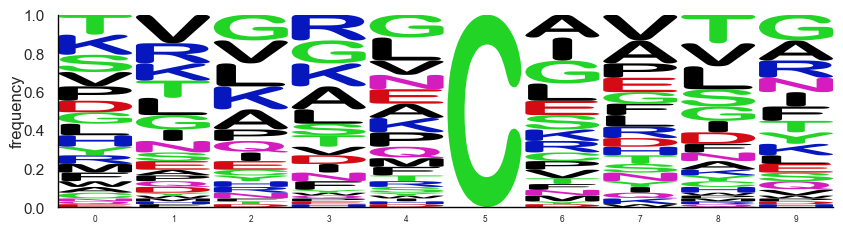

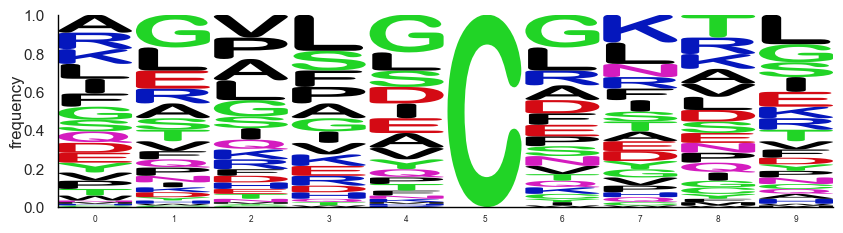

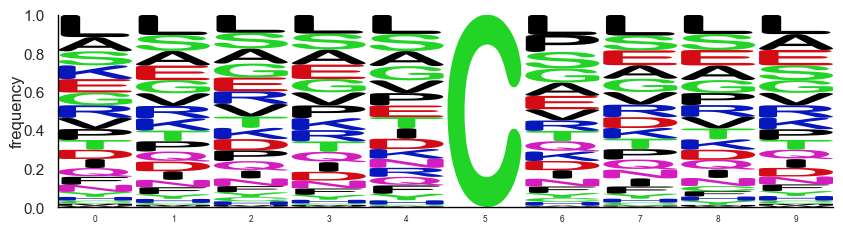

In [165]:
for col in ratio_combfiles.filter(like="regulation").columns:
    print(col)
    for regulation in ["Higher", "Lower", "Unchanged"]:
        subset = ratio_combfiles[ratio_combfiles[col] == regulation].copy()
        logo = make_logo_plot(subset)
        logo.fig.savefig("{}_{}.png".format(col.split("_+")[0], regulation))

Format sequence context and save

In [166]:
uniprot = read_fasta('/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Vinogradova Laboratory/Henry_data processing/03_fasta_files/homo_sapiens/20240312/uniprotkb_proteome_UP000005640_AND_revi_2024_03_12.fasta')
ratio_combfiles["uniprot_sequence"] = ratio_combfiles["uniprot"].apply(lambda x: uniprot[x])
ratio_combfiles["residue_loc"] = ratio_combfiles["residue"].apply(lambda x: int(x.split("C")[1].split(",")[0]))
ratio_combfiles = ratio_combfiles.apply(fetch_flanking_seq, axis = 1)
ratio_combfiles.to_csv(add_back_dir / "06_results/ATP_reactivity_with_flanking_sequences.csv")

In [167]:
add_back_dir

PosixPath('/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/10_metabolites/02_rc_analysis/20241107_tex_metab_2reps_2MC')

In [168]:
ratio_combfiles.flanking_seq = ratio_combfiles.flanking_seq.str.pad(10, side='right', fillchar='_')
ratio_combfiles["flanking_seq_for_logo"] = (
    ratio_combfiles["flanking_seq"].str[:5]
    + "_"
    + ratio_combfiles["flanking_seq"].str[6:]
)
ratio_combfiles[
    ratio_combfiles.ATP_sensitivity_D8C_vs_D2 == "More ATP sensitive at D8C"
].flanking_seq_for_logo.to_csv("flanking_seq_D8C.fasta", index=None, header=None)


ratio_combfiles.flanking_seq = ratio_combfiles.flanking_seq.str.pad(10, side='right', fillchar='_')
ratio_combfiles["flanking_seq_for_logo"] = (
    ratio_combfiles["flanking_seq"].str[:5]
    + "_"
    + ratio_combfiles["flanking_seq"].str[6:]
)
ratio_combfiles[
    ratio_combfiles.ATP_sensitivity_D8C_vs_D2 == "Unchanged"
].flanking_seq_for_logo.to_csv("flanking_seq_unchanged.fasta", index=None, header=None)

In [169]:
set(ratio_combfiles.ATP_sensitivity_D8C_vs_D2)

{'More ATP sensitive at D2', 'More ATP sensitive at D8C', 'Unchanged'}

In [170]:
ratio_combfiles.flanking_seq = ratio_combfiles.flanking_seq.str.pad(10, side='right', fillchar='_')
ratio_combfiles["flanking_seq_for_logo"] = (
    ratio_combfiles["flanking_seq"].str[:5]
    + "_"
    + ratio_combfiles["flanking_seq"].str[6:]
)
ratio_combfiles[
    ratio_combfiles["regulation_D8A_+/-_ATP"] == "Lower"
].flanking_seq_for_logo.to_csv("flanking_seq_D8C.fasta", index=None, header=None)